[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/khigashi1987/scanpy_handson_utokyolec2024/blob/main/scanpy_handson_colab.ipynb)

# PythonによるscRNA-seq解析

必要なデータのダウンロードとツールのインストール。

In [73]:
!git clone https://github.com/khigashi1987/scanpy_handson_utokyolec2024.git

Cloning into 'scanpy_handson_utokyolec2024'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 29 (delta 1), reused 5 (delta 0), pack-reused 21
Receiving objects: 100% (29/29), 156.29 MiB | 24.71 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Updating files: 100% (13/13), done.


In [3]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:12
🔁 Restarting kernel...


In [1]:
!conda install -y -c conda-forge scanpy python-igraph leidenalg

Channels:
 - conda-forge
Platform: linux-64
Solving environment: \ | / - \ | done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.5.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - leidenalg
    - python-igraph
    - scanpy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    anndata-0.10.7             |     pyhd8ed1ab_0          96 KB  conda-forge
    arpack-3.8.0               |nompi_h0baa96a_101         214 KB  conda-forge
    array-api-compat-1.7.1     |     pyhd8ed1ab_0          32 KB  conda-forge
    brotli-1.1.0               |       hd590300_1          19 KB  conda-forge
    brotli-bin-1.1.0           |       hd590300_1          19 KB  conda-forge
    ca-certificates-2024.6.2   |       hbcca054

In [2]:
 !pip install -U scvelo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 41.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached click-8.1.7-py3-none-any.whl.metadata (3.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.1/210.1 kB 13.4 MB/s eta 0:00:00
Using cached click-8.1.7-py3-none-any.whl (97 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 2.6 MB/s eta 0:00:00
  Created wheel for loompy: filename=loompy-3.0.7-py3-none-any.whl size=52018 sha256=5b80634a7cf93e5fab2923aa5922d2a83d4fc2af93ea5d91cf9b54bb1ff9193c
  Stored in directory: /root/.cache/pip/wheels/2c/22/1f/792a4621bb631e538bf1c21feae9bbaa6b19fd6d6ab382d1fd
Successfully built loompy


In [3]:
!pip install --quiet scvi-colab
from scvi_colab import install
install()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.7/240.7 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.5/87.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 20.8 MB/s eta 0:00:00
INFO     scvi-colab: Installing scvi-tools.                                                                        
INFO     scvi-colab: Install successful. Testing import.                                                           


In [9]:
%cd scanpy_handson_utokyolec2024

/content/scanpy_handson_utokyolec2024


## 使用データ

マウス15.5日胚の眼球から取り出した網膜の細胞。10X Chromium 3′ v2で解析。2つのReplicatesでそれぞれ約2,600細胞。

Mouse developing retina from Lo Giudice et al. [https://doi.org/10.1242/dev.178103](https://doi.org/10.1242/dev.178103)

Lo Giudice, Q., Leleu, M., La Manno, G. & Fabre, P. J. Single-cell transcriptional logic of cell-fate specification and axon guidance in early-born retinal neurons. Development 146, dev178103 (2019).

## Pythonに関係ない部分の解析

### データのダウンロード

好きな方法で公共データベースからダウンロードする。レプリケイトがふたつあって、それぞれ以下のSRR IDに対応。
```bash
fastq-dump SRR8181428 --split-files --gzip
fastq-dump SRR8181429 --split-files --gzip
```

### Cell Rangerによる解析

Cell Rangerでマウスゲノム（mm10）へのマッピング、遺伝子ごとのカウントを実行。

レプリケイトは（論文でそう名付けられてたので）E2, F2という名前のバッチに設定。

```bash
cellranger count --id=RetinalBatchE2 \
   --fastqs=/path/to/SRR8181428\
   --sample=SRR8181428 \
   --transcriptome=/path/to/Cell_Ranger_References/refdata-gex-mm10-2020-A

cellranger count --id=RetinalBatchF2 \
   --fastqs=/path/to/SRR8181429\
   --sample=SRR8181429 \
   --transcriptome=/path/to/Cell_Ranger_References/refdata-gex-mm10-2020-A
```

講習では、このCell Ranger解析の結果ディレクトリ（の一部、講習で使う部分だけを抜き出したもの）を配布している。

こんな感じの構成になっていて、Cell Rangerのアウトプットが見えるはず。velocytoは後半で解説。

```bash
./data
├── RetinalBatchE2
│   ├── outs
│   │   ├── filtered_feature_bc_matrix
│   │   │   ├── barcodes.tsv.gz
│   │   │   ├── features.tsv.gz
│   │   │   └── matrix.mtx.gz
│   │   └── web_summary.html
│   └── velocyto
│       └── RetinalBatchE2.loom
├── RetinalBatchF2
│   ├── outs
│   │   ├── filtered_feature_bc_matrix
│   │   │   ├── barcodes.tsv.gz
│   │   │   ├── features.tsv.gz
│   │   │   └── matrix.mtx.gz
│   │   └── web_summary.html
│   └── velocyto
│       └── RetinalBatchF2.loom
├── retinal.h5ad
└── retinal_velo.loom

8 directories, 12 files
```

## ライブラリのimport

定番のライブラリのimportに加えて、scanpyをscの別名でimportする。

Figのちょっとした設定。あと一応、筆者の環境における各ライブラリのバージョンは以下の通り。

In [4]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

sc.logging.print_header()
sc.settings.set_figure_params(dpi=100, facecolor='white')

scanpy==1.10.1 anndata==0.10.7 umap==0.5.5 numpy==1.25.2 scipy==1.13.1 pandas==2.2.2 scikit-learn==1.5.0 statsmodels==0.14.2 igraph==0.11.5 pynndescent==0.5.12


## データの読み込み

Scanpyの特徴は、データフレームを拡張した ***anndata*** と呼ばれる オブジェクトを使う点にある。anndataを使うと、ひとつのオブジェクトに遺伝子発現量のデータ、サンプルや細胞のアノテーション、遺伝子の情報などをまとめて格納できる。 anndataを使うことで、実験の情報が詰まったひとつのオブジェクトに対して処理を次々に実行し、さらに処理結果をそこに蓄積していくことができる。

Scanpyでは、10x Genomicsのデータは、結果のディレクトリを指定することでそのままロードが可能な関数が用意されている。

ディレクトリには、3つのファイルが書き出されている。

ひとつは、個別の細胞を識別するバーコードが記述されたbarcodes.tsvという名前のテキストファイル。各行ごとにひとつのバーコードが記述されている。

ふたつめは、計測された遺伝子が記述されたgenes.tsvという名前のタブ区切りテキストファイル。このファイルは左側の列に遺伝子のENSEMBL Gene ID、右側の列の遺伝子のシンボルが記述されている。

最後にmatrix.mtxというテキストファイルが、各細胞（バーコード）について各遺伝子の発現がいくつ観測されたのかカウント情報をまとめたファイル。このファイルはMatrix Market Exchange Formatsという形式で記述されており、疎行列（含まれる値の多くがゼロであるような行列）を比較的コンパクトに記述するための形式となっている。

Scanpyの10xデータ用読み込み関数を使うと、これらを同時に読み込んで、適切に構造化されたオブジェクトができあがる。

In [10]:
adata_E2 = sc.read_10x_mtx(path='./data/RetinalBatchE2/outs/filtered_feature_bc_matrix/', cache=True)
adata_F2 = sc.read_10x_mtx(path='./data/RetinalBatchF2/outs/filtered_feature_bc_matrix/', cache=True)

In [11]:
adata_E2

AnnData object with n_obs × n_vars = 3611 × 32285
    var: 'gene_ids', 'feature_types'

In [12]:
adata_F2

AnnData object with n_obs × n_vars = 3392 × 32285
    var: 'gene_ids', 'feature_types'

2つのバッチをひとつのanndataオブジェクトに統合する。バッチのラベルもここで設定。

In [13]:
adata = adata_E2.concatenate(adata_F2, batch_categories=['E2', 'F2'])

観測値（細胞）に関するデータは、**obs** でアクセスする。 observationsの略。このデータフレームに細胞に関するデータを追加していくことができる。

In [14]:
adata.obs

batch
AAACCTGAGTGGACGT-1-E2    E2
AAACCTGCATCCGCGA-1-E2    E2
AAACCTGGTCGAATCT-1-E2    E2
AAACCTGTCAGTCCCT-1-E2    E2
AAACCTGTCCAAACAC-1-E2    E2
...                     ...
TTTGTCACAGCTGTTA-1-F2    F2
TTTGTCAGTAAGAGGA-1-F2    F2
TTTGTCATCCCACTTG-1-F2    F2
TTTGTCATCCCATTTA-1-F2    F2
TTTGTCATCTTGCCGT-1-F2    F2

[7003 rows x 1 columns]

変数（遺伝子）に関するデータは、**var** でアクセスする。variable の略。現在は、遺伝子のシンボル（名前）と、Ensembl Gene IDなどが登録されている。

In [15]:
adata.var

gene_ids    feature_types
Xkr4        ENSMUSG00000051951  Gene Expression
Gm1992      ENSMUSG00000089699  Gene Expression
Gm19938     ENSMUSG00000102331  Gene Expression
Gm37381     ENSMUSG00000102343  Gene Expression
Rp1         ENSMUSG00000025900  Gene Expression
...                        ...              ...
AC124606.1  ENSMUSG00000095523  Gene Expression
AC133095.2  ENSMUSG00000095475  Gene Expression
AC133095.1  ENSMUSG00000094855  Gene Expression
AC234645.1  ENSMUSG00000095019  Gene Expression
AC149090.1  ENSMUSG00000095041  Gene Expression

[32285 rows x 2 columns]

カウントテーブルには、以下のように ***X*** でアクセスできる。疎行列として格納されている。

In [16]:
adata.X

<7003x32285 sparse matrix of type '<class 'numpy.float32'>'
	with 14123833 stored elements in Compressed Sparse Row format>

In [17]:
adata

AnnData object with n_obs × n_vars = 7003 × 32285
    obs: 'batch'
    var: 'gene_ids', 'feature_types'

## 前処理

観測された遺伝子が極端に少ない細胞、割り当てられた細胞が極端に少ない遺伝子をフィルタリング。

In [18]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=20)

In [19]:
adata

AnnData object with n_obs × n_vars = 7001 × 15001
    obs: 'batch', 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells'

ミトコンドリア遺伝子の発現割合でフィルタリングする予定なので、遺伝子側のメタデータにミトコンドリア遺伝子か否かの情報を付与。

In [20]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')

以下は、クオリティコントロールに関連したいくつかの指標を一挙に計算してくれる便利な関数。

`qc_vars`に遺伝子側のメタデータラベルを設定すると、それについてもカウントとパーセンテージを勝手に計算してくれる。

In [21]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [22]:
adata.obs

batch  n_genes  n_genes_by_counts  total_counts  \
AAACCTGAGTGGACGT-1-E2    E2     3606               3599       10366.0   
AAACCTGCATCCGCGA-1-E2    E2      659                659        1114.0   
AAACCTGGTCGAATCT-1-E2    E2     2321               2317        4991.0   
AAACCTGTCAGTCCCT-1-E2    E2     1432               1431        2491.0   
AAACCTGTCCAAACAC-1-E2    E2     3927               3914       11848.0   
...                     ...      ...                ...           ...   
TTTGTCACAGCTGTTA-1-F2    F2      835                834        1653.0   
TTTGTCAGTAAGAGGA-1-F2    F2     3476               3470        8582.0   
TTTGTCATCCCACTTG-1-F2    F2     1707               1704        3376.0   
TTTGTCATCCCATTTA-1-F2    F2     1589               1586        2798.0   
TTTGTCATCTTGCCGT-1-F2    F2     1907               1905        3639.0   

                       total_counts_mt  pct_counts_mt  
AAACCTGAGTGGACGT-1-E2            236.0       2.276674  
AAACCTGCATCCGCGA-1-E2              1.0       0.089767  
AAACCTGGTCGAATCT-1-E2            115.0       2.304147  
AAACCTGTCAGTCCCT-1-E2             47.0       1.886792  
AAACCTGTCCAAACAC-1-E2            187.0       1.578325  
...                                ...            ...  
TTTGTCACAGCTGTTA-1-F2              5.0       0.302480  
TTTGTCAGTAAGAGGA-1-F2            218.0       2.540200  
TTTGTCATCCCACTTG-1-F2            130.0       3.850711  
TTTGTCATCCCATTTA-1-F2              8.0       0.285919  
TTTGTCATCTTGCCGT-1-F2              9.0       0.247321  

[7001 rows x 6 columns]

それぞれの分布をプロット。

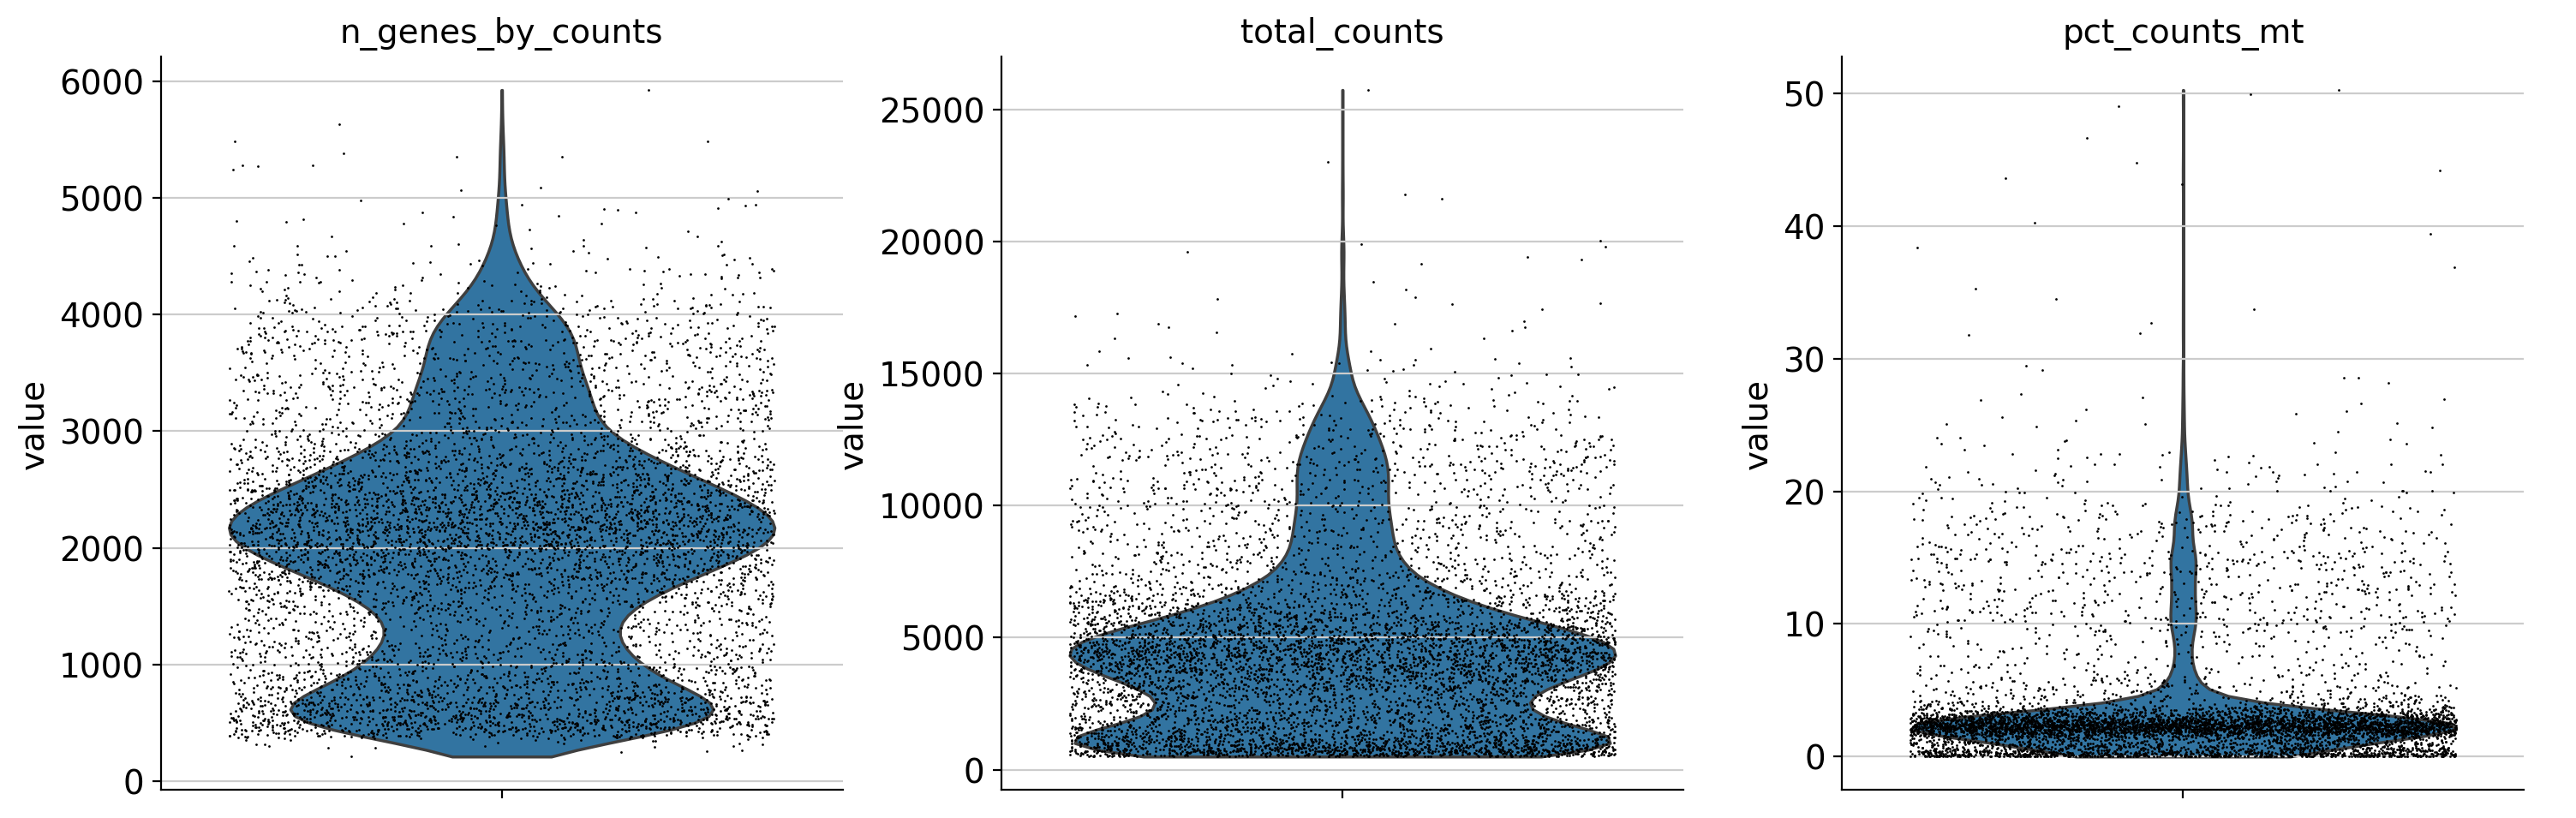

In [23]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

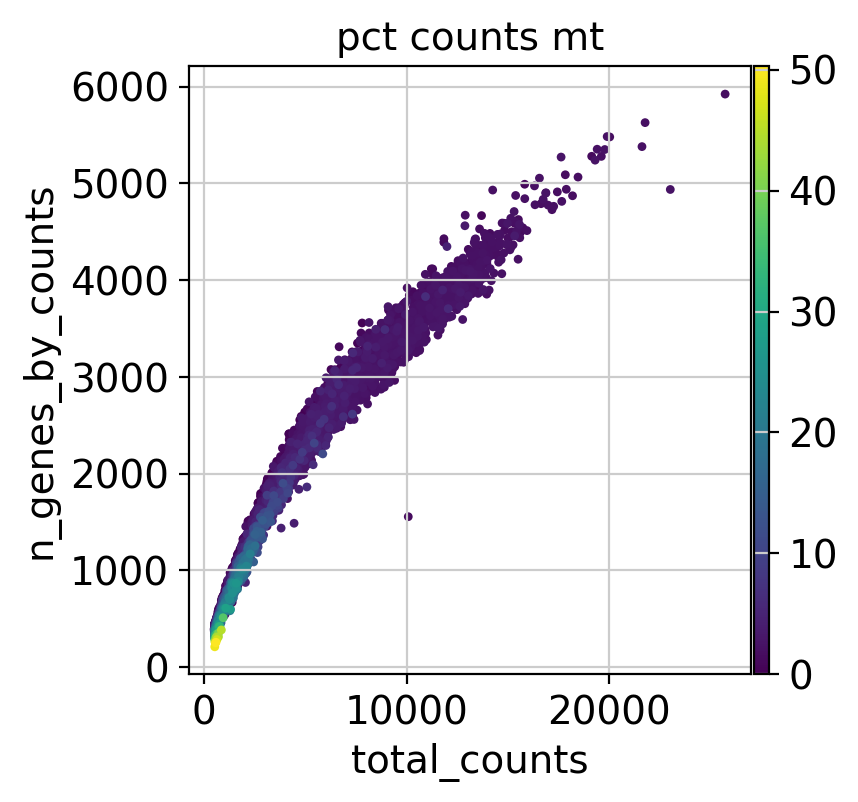

In [24]:
sc.pl.scatter(adata, 'total_counts', 'n_genes_by_counts', color='pct_counts_mt', size=40)

<Figure size 400x400 with 0 Axes>

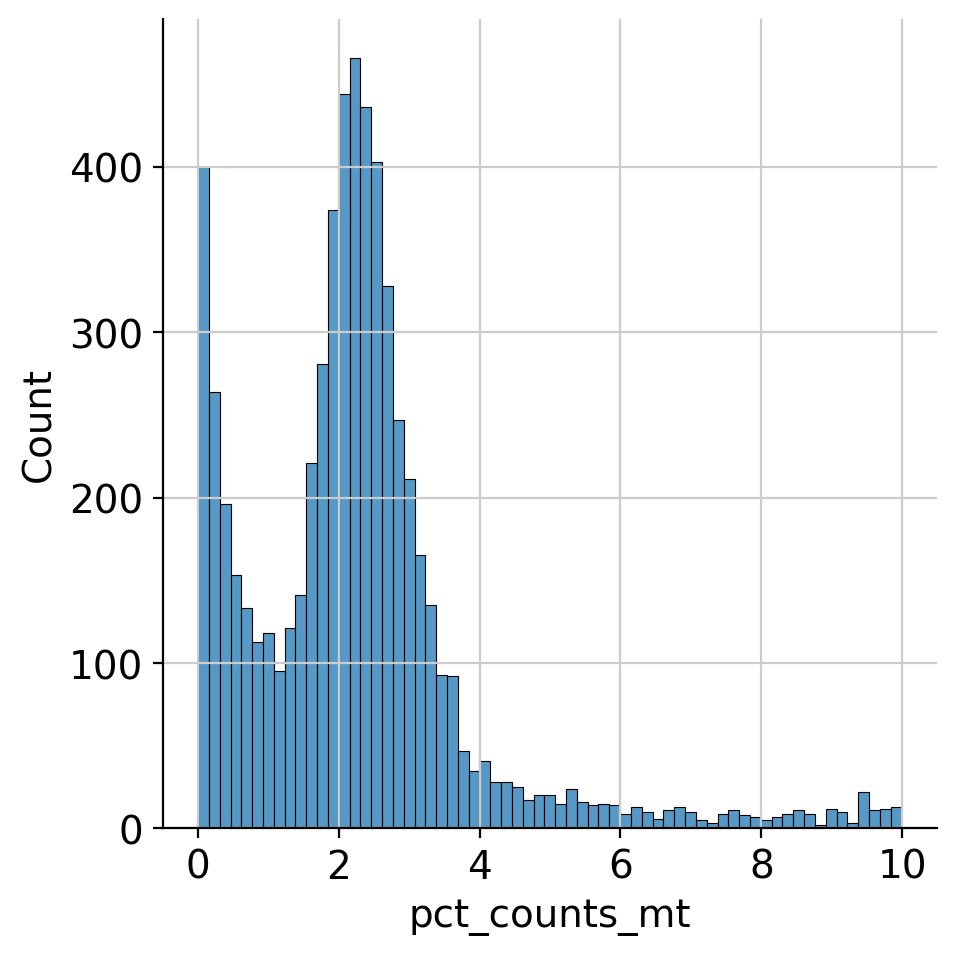

In [25]:
fig = plt.figure()
sns.displot(adata.obs['pct_counts_mt'][adata.obs['pct_counts_mt'] < 10], kde=False)
plt.show()

分布を見て方針を決めて、フィルタリングを実行。

In [26]:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = 2000)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts = 13000)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 1000)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

adata = adata[adata.obs['pct_counts_mt'] < 6]
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))

Total number of cells: 7001
Number of cells after min count filter: 5174
Number of cells after max count filter: 4981
Number of cells after gene filter: 4976
Number of cells after MT filter: 4773


In [27]:
adata

View of AnnData object with n_obs × n_vars = 4773 × 15001
    obs: 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

正規化や対数変換などの前に、この段階のカウントマトリックスを別のレイヤーに退避させておく。あとで確率モデル推定のときに必要になる。レイヤーに保管したデータは基本的に以降の操作の影響を受けないが、細胞や遺伝子のslicingは適用されるので注意。（常にマトリックスのshapeは一致する）

In [28]:
adata.layers['counts'] = adata.X.copy()

## 正規化

ライブラリサイズによる正規化、対数変換などの前処理は、scanpy.pp以下にいくつか便利な関数がある。

ここでは、細胞ごとのカウントの和が10,000になるように正規化してから、対数変換。

In [29]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

この段階のデータ（いろいろとややこしい変換をしていない「ピュア」なデータ）も、あとでプロットや結果解釈のときに使いたいので退避させておく。rawは特別なレイヤーで、数値だけでなくobsやvarのメタデータも含めてフリーズしてくれる。また遺伝子側のsliceの影響を受けない（細胞側のsliceは適用される）

In [30]:
adata.raw = adata

## 特徴量選択（発現量の変動が大きい遺伝子）

発現量変動の大きい遺伝子のみを抽出して、データのサイズを小さくする。

In [31]:
sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=2000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))


 Number of highly variable genes: 2000


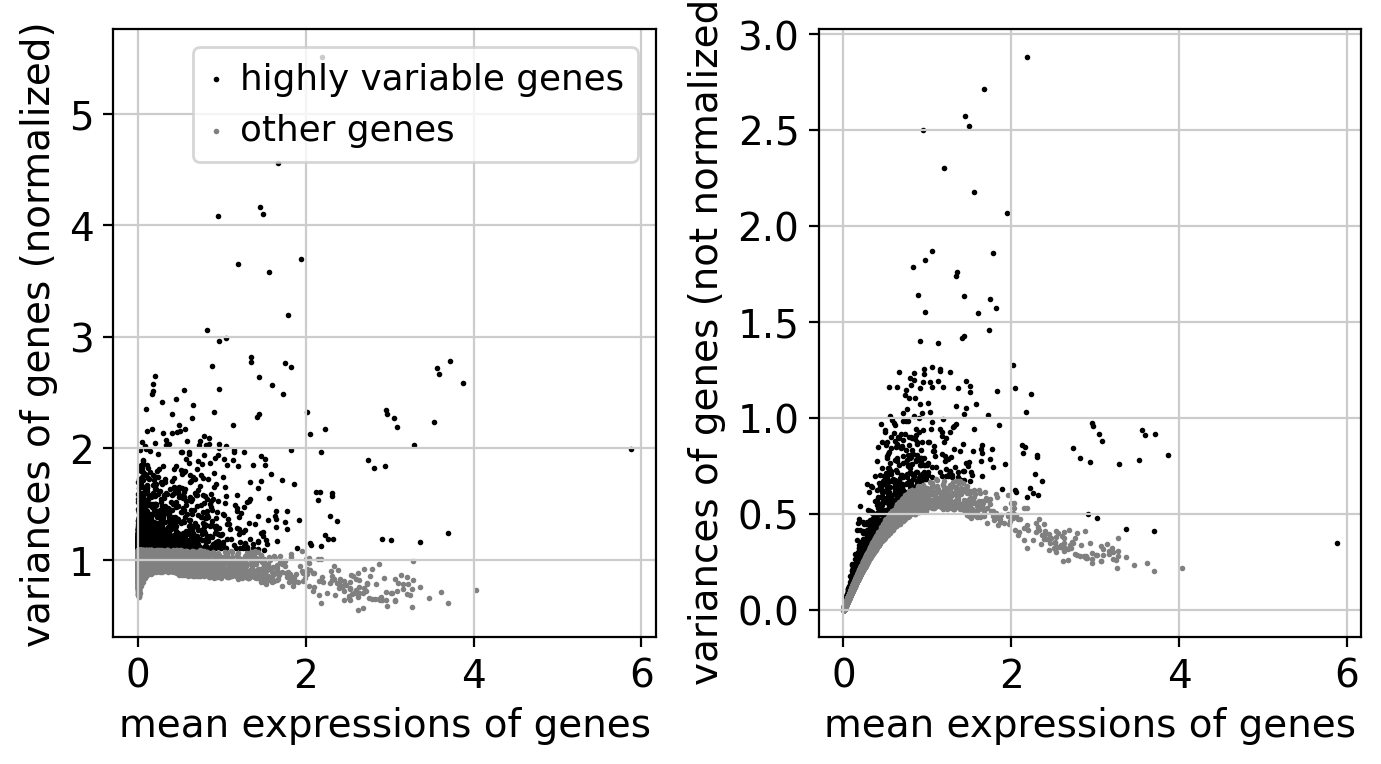

In [32]:
sc.pl.highly_variable_genes(adata)

計算結果は自動的に adata.var 、つまり、遺伝子に関するメタデータを格納したオブジェクトに追加される。 highly_variable の項目が True の遺伝子が高発現変動遺伝子。

In [33]:
adata.var

gene_ids    feature_types  n_cells     mt  \
Xkr4            ENSMUSG00000051951  Gene Expression     2817  False   
Gm1992          ENSMUSG00000089699  Gene Expression      533  False   
Gm19938         ENSMUSG00000102331  Gene Expression      588  False   
Rp1             ENSMUSG00000025900  Gene Expression       21  False   
Mrpl15          ENSMUSG00000033845  Gene Expression     1963  False   
...                            ...              ...      ...    ...   
CAAA01118383.1  ENSMUSG00000063897  Gene Expression      205  False   
Vamp7           ENSMUSG00000051412  Gene Expression     1735  False   
Tmlhe           ENSMUSG00000079834  Gene Expression      738  False   
4933409K07Rik   ENSMUSG00000095552  Gene Expression       20  False   
AC149090.1      ENSMUSG00000095041  Gene Expression     2249  False   

                n_cells_by_counts  mean_counts  pct_dropout_by_counts  \
Xkr4                         2817     1.286673              59.762891   
Gm1992                        533     0.088416              92.386802   
Gm19938                       588     0.096843              91.601200   
Rp1                            21     0.004142              99.700043   
Mrpl15                       1963     0.359234              71.961148   
...                           ...          ...                    ...   
CAAA01118383.1                205     0.029853              97.071847   
Vamp7                        1735     0.315241              75.217826   
Tmlhe                         738     0.117269              89.458649   
4933409K07Rik                  20     0.002857              99.714327   
AC149090.1                   2249     0.533210              67.876018   

                total_counts  highly_variable  highly_variable_rank     means  \
Xkr4                  9008.0             True                 297.0  0.705977   
Gm1992                 619.0            False                   NaN  0.066624   
Gm19938                678.0            False                   NaN  0.095603   
Rp1                     29.0             True                 328.0  0.005833   
Mrpl15                2515.0            False                   NaN  0.418329   
...                      ...              ...                   ...       ...   
CAAA01118383.1         209.0            False                   NaN  0.037380   
Vamp7                 2207.0            False                   NaN  0.355340   
Tmlhe                  821.0            False                   NaN  0.115620   
4933409K07Rik           20.0            False                   NaN  0.002168   
AC149090.1            3733.0            False                   NaN  0.450506   

                variances  variances_norm  
Xkr4             0.801317        1.482216  
Gm1992           0.067288        0.948646  
Gm19938          0.097265        0.966634  
Rp1              0.009065        1.444276  
Mrpl15           0.345507        0.920237  
...                   ...             ...  
CAAA01118383.1   0.039742        0.986127  
Vamp7            0.302597        0.919710  
Tmlhe            0.118467        0.981572  
4933409K07Rik    0.001512        0.771752  
AC149090.1       0.409558        1.028776  

[15001 rows x 13 columns]

## 主成分分析（PCA）

PCAはscanpyの前処理関数で簡単に実行できる。とりあえず、50次元まで落としてみる。 use_highly_variableのフラグをオンにすると、遺伝子全体ではなく前項で決定した高発現変動遺伝子のみを使って次元削減をする。

In [34]:
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')

PCAで落とした座標は、観察値のメタデータを格納する ***obsm*** に自動的に入る。obsm は Multi-dimensional annotation of observations の略。複数の次元でひとつの何かを表現するような観測値のメタデータがここに格納される。

In [35]:
print(adata.obsm['X_pca'].shape)

(4773, 50)


プロットしてみる。Scanpyでは基本的に「前処理」（Preprocessing）に関わる関数がscanpy.ppに、「プロット」（Plot）に関わる関数がscanpy.plに入っている。

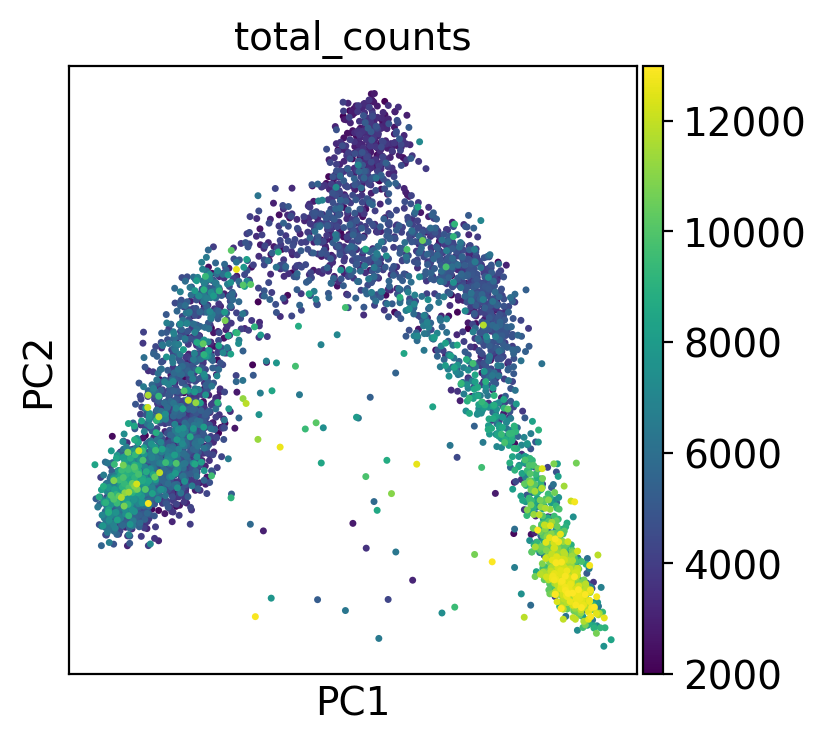

In [36]:
sc.pl.pca(adata, color='total_counts')

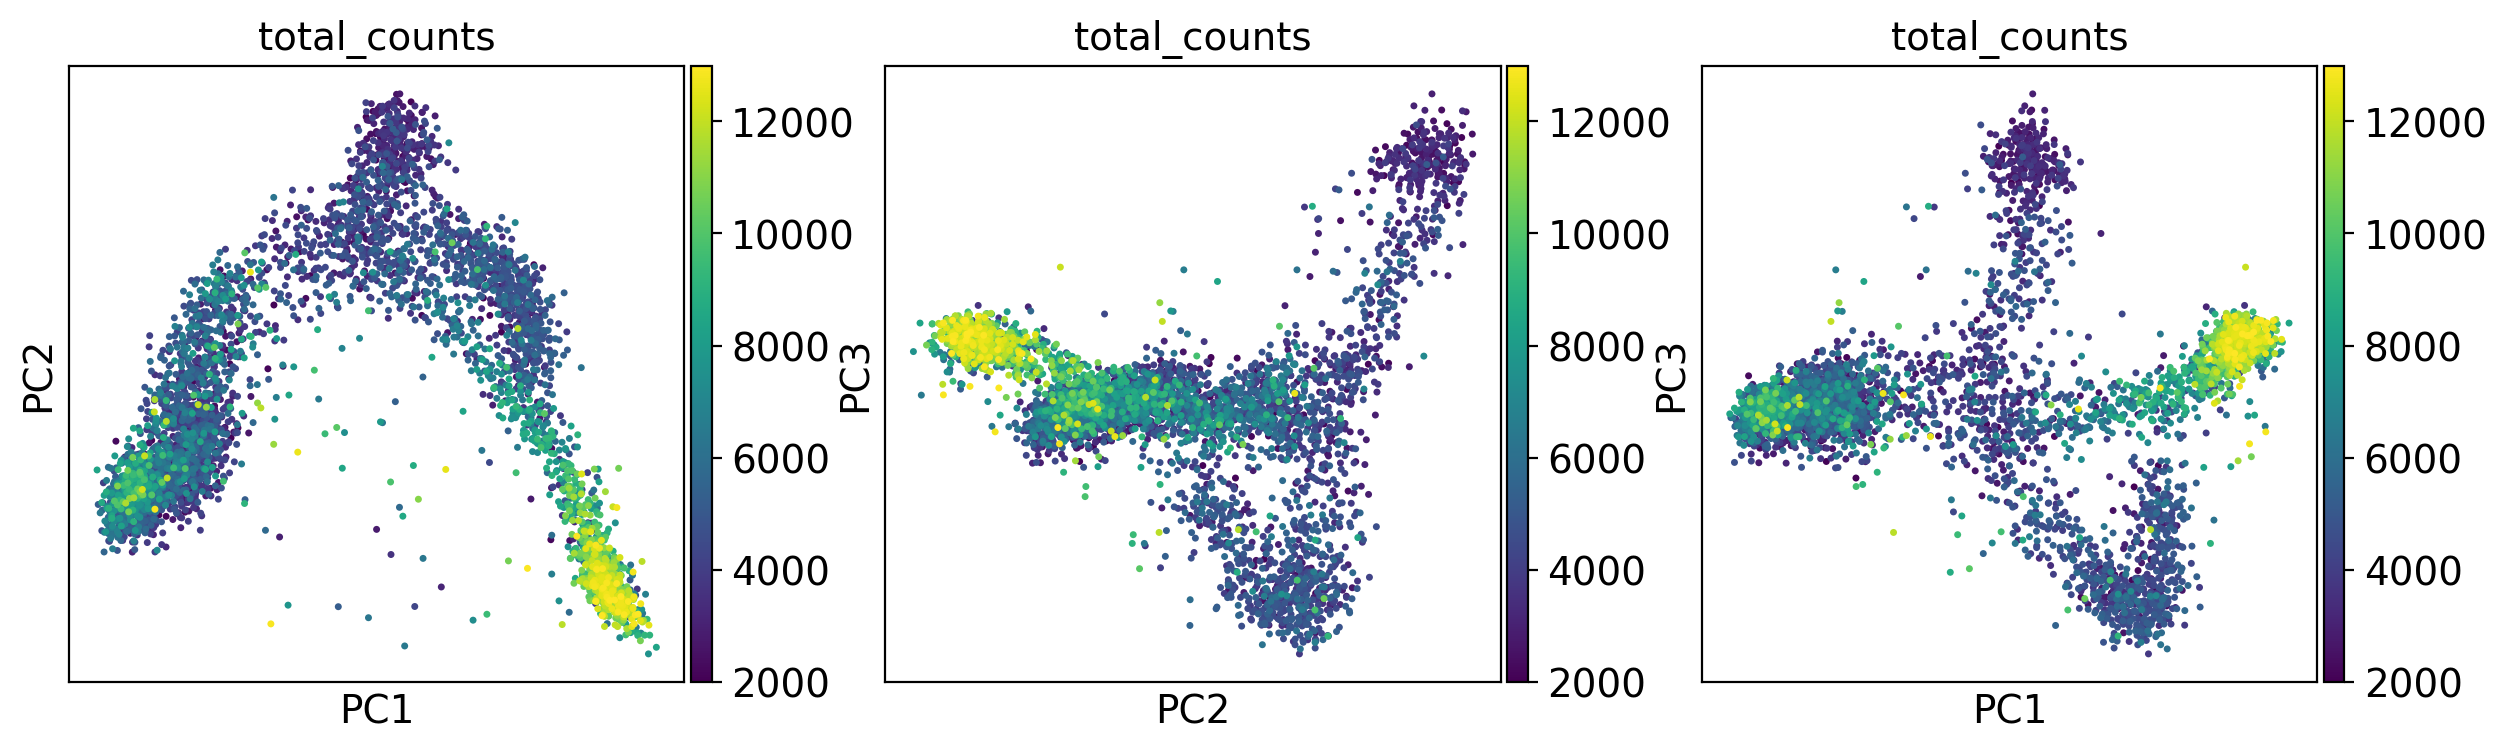

In [37]:
sc.pl.pca(adata, color='total_counts',
          components=['1,2', '2,3', '1,3'])

In [38]:
# projection='3d'
# を指定すると3次元表示（見づらい）

## UMAP

まず、t-SNE, UMAP共通のステップとして、データから「近傍グラフ」（neighborhood graph）の構築が必要。

In [39]:
sc.pp.neighbors(adata)

データ点間の接続関係（細胞の近傍関係）は、全細胞vs.全細胞のペアの情報を記録する ***obsp*** （Pairwise annotation of observations の略）に格納される。

In [40]:
adata.obsp['connectivities']

<4773x4773 sparse matrix of type '<class 'numpy.float32'>'
	with 95996 stored elements in Compressed Sparse Row format>

In [41]:
sc.tl.umap(adata)

プロットはt-SNEとほとんど同じ。scanpy.pl以下にUMAP用の描画関数がある。

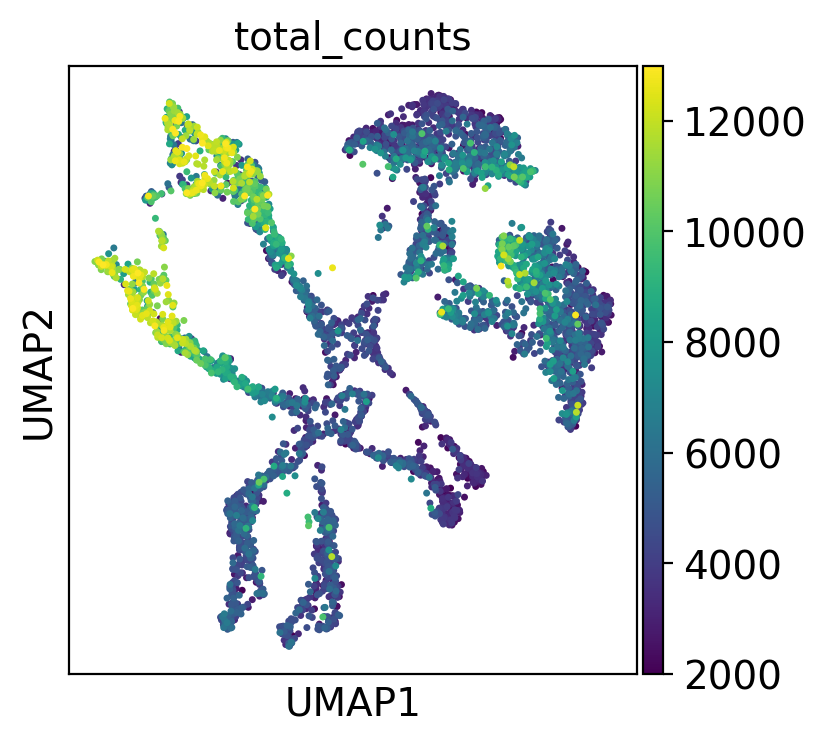

In [42]:
sc.pl.umap(adata, color='total_counts')

あきらかに似た形状の、ふたつの構造がある。。。

各細胞が由来するバッチで色分けしてみると・・・

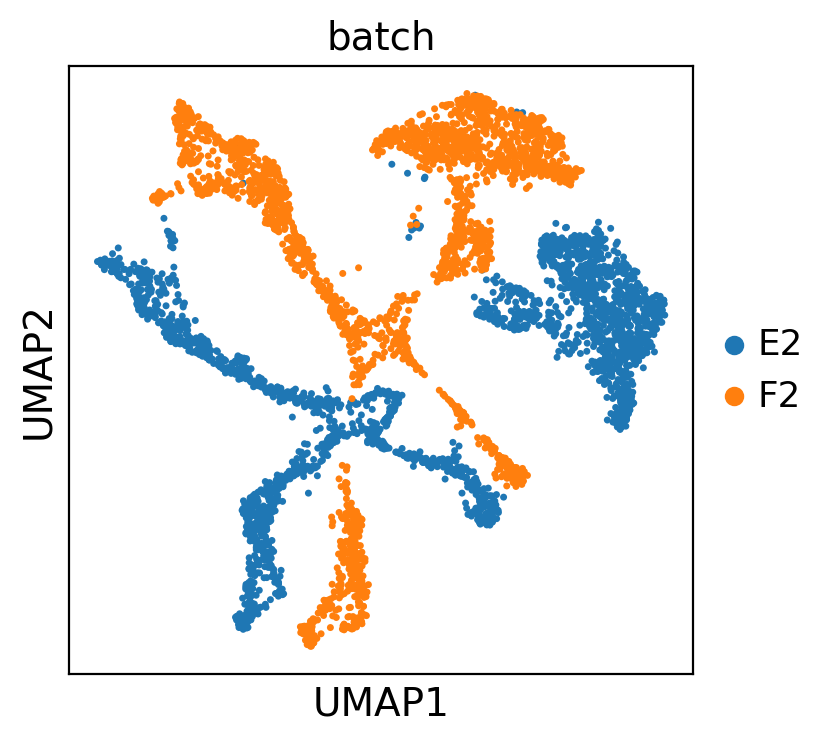

In [43]:
sc.pl.umap(adata, color='batch')

ということで、このふたつの構造はもろにバッチ効果の結果だった。なんらかの方法で補正が必要だが、それは後述。

## クラスタリング

Leidenクラスタリングを実行してみる。モジュラリティの計算に影響を与える "resolution" パラメータが存在する。

In [44]:
sc.tl.leiden(adata, resolution=0.5, key_added='leiden_r0.5')

クラスタリングの結果は観測値のメタデータ（obs）の中に格納される。

In [45]:
adata.obs

batch  n_genes  n_genes_by_counts  total_counts  \
AAACCTGAGTGGACGT-1-E2    E2     3599               3599       10366.0   
AAACCTGGTCGAATCT-1-E2    E2     2317               2317        4991.0   
AAACCTGTCAGTCCCT-1-E2    E2     1431               1431        2491.0   
AAACCTGTCCAAACAC-1-E2    E2     3914               3914       11848.0   
AAACGGGCACTGAAGG-1-E2    E2     3009               3009        7528.0   
...                     ...      ...                ...           ...   
TTTGTCACACTAGTAC-1-F2    F2     2584               2584        5563.0   
TTTGTCAGTAAGAGGA-1-F2    F2     3470               3470        8582.0   
TTTGTCATCCCACTTG-1-F2    F2     1704               1704        3376.0   
TTTGTCATCCCATTTA-1-F2    F2     1586               1586        2798.0   
TTTGTCATCTTGCCGT-1-F2    F2     1905               1905        3639.0   

                       total_counts_mt  pct_counts_mt  n_counts leiden_r0.5  
AAACCTGAGTGGACGT-1-E2            236.0       2.276674   10366.0          14  
AAACCTGGTCGAATCT-1-E2            115.0       2.304147    4991.0           3  
AAACCTGTCAGTCCCT-1-E2             47.0       1.886792    2491.0           5  
AAACCTGTCCAAACAC-1-E2            187.0       1.578325   11848.0           6  
AAACGGGCACTGAAGG-1-E2            127.0       1.687035    7528.0           9  
...                                ...            ...       ...         ...  
TTTGTCACACTAGTAC-1-F2             13.0       0.233687    5563.0           4  
TTTGTCAGTAAGAGGA-1-F2            218.0       2.540200    8582.0          13  
TTTGTCATCCCACTTG-1-F2            130.0       3.850711    3376.0           4  
TTTGTCATCCCATTTA-1-F2              8.0       0.285919    2798.0           1  
TTTGTCATCTTGCCGT-1-F2              9.0       0.247321    3639.0           1  

[4773 rows x 8 columns]

プロットする点の座標じたいはUMAPの結果なので、プロットはUMAP版の関数を使い、色分けだけをクラスタリング結果で指定すればいい。

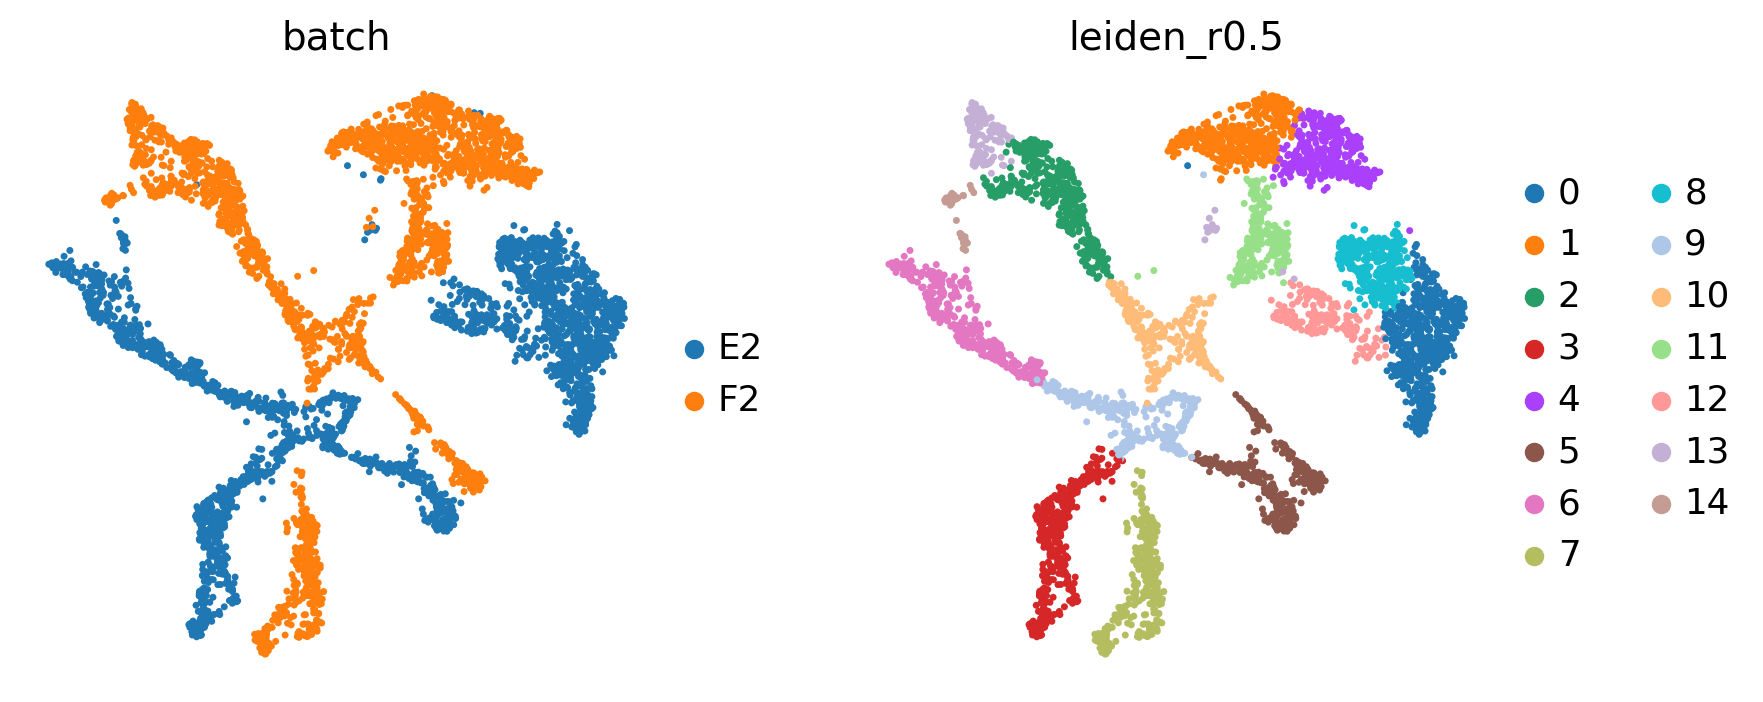

In [46]:
sc.pl.umap(adata,
           color=['batch', 'leiden_r0.5'],
           ncols=2,
           frameon=False)

## 深層生成モデルの利用

scVIが仮定しているデータの生成プロセスは以下の確率モデルに基づく。

全細胞数がN, 細胞のインデックスが $n \in \{1..N\}$、全遺伝子数がG、遺伝子のインデックスが $g \in \{1..G\}$、細胞nのバッチIDが$s_n$であるとしたとき、細胞nの遺伝子gのカウントは、

$$z_n \sim Normal(0, I)$$

$$l_n \sim logNormal(l_\mu, l_\sigma^2)$$

$$\rho_n = f_w (z_n, s_n)$$

$$w_{ng} = Gamma(\rho_n^g, \theta)$$

$$y_{ng} = Poisson(l_n w_{ng})$$

$$h_{ng} = Bernoulli( f_h^g(z_n, s_n) )$$

$$
  \begin{equation}
    x_{ng} =
    \begin{cases}
      y_{ng} & \text{if}\ h_{ng}=0 \\
      0 & \text{otherwise}
    \end{cases}
  \end{equation}
$$

$l_\mu, l_\sigma$は、スケーリングファクターでバッチの数をBとしたとき$l_\mu,l_\sigma \in \mathbb{R}^B$で、実際のバッチごとの平均と分散に設定しておく。

ガンマ分布のパラメータ、ベルヌーイ分布のパラメータは、正規分布からサンプリングした$z_n$を使ってニューラルネットワークで表現する（VAEにおけるreparametrization trick）。

最終的なカウントはガンマとポアソンの複合分布なので、負の二項分布でモデル化してることになる。さらにベルヌーイ分布で、scRNA-seqにありがちなdrop-outイベントを表現。これらの組み合わせで、ゼロ過剰負の二項分布(Zero-inflated negative binomial distribution; ZINB)を表現している。

事後分布はVAEをSGDで最適化して変分推論。

学習後、$z_n$にアクセスすれば、バッチの効果が除去された細胞の潜在ベクトルが得られるし、$\rho_{ng}$にアクセスすればdrop-outなどのイベントが生じなかった場合の遺伝子発現の期待値が得られる。

In [47]:
import scvi

データを格納したanndataオブジェクトと、バッチのIDを指定したobsのカラムのラベルを指定して、モデルをセットアップする。カウントデータの確率モデルなので、（正規化や対数変換したマトリックスではなく）カウントデータを格納したレイヤーを指定する必要があることに注意。

In [48]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer='counts',
    batch_key='batch',
)

モデルを作る。ここで中間層のノード数とか潜在ベクトルの次元サイズなど設定できるが、とくに変更しなくていいと思う。

In [49]:
model = scvi.model.SCVI(adata)

### scVIモデルのトレーニング（バッチ補正）

学習を実行する。GPU使わない場合はめっちゃ時間かかるので今回の講習では割愛。学習済みのモデルパラメータを用意したのでそれをロードして学習できたことにする。

In [50]:
# model.train()

In [51]:
# model.save('./models/scVI_model', overwrite=True)

In [52]:
model = scvi.model.SCVI.load('./models/scVI_model', adata=adata)

INFO     File ./models/scVI_model/model.pt already downloaded                                                      


学習された細胞ごとの潜在表現$z_n$は以下の関数で取得できる。PCAやUMAPの座標と同じように、obsmに格納しておく。

In [53]:
adata.obsm['X_scVI'] = model.get_latent_representation()

発現量期待値 $\rho_{ng}$ 、つまりdenoiseされた発現量テーブルは以下の関数で取得できる。適当なライブラリサイズで規格化してくれる。この数値はあとで使いたいので別のレイヤーに格納しておく。

In [54]:
adata.layers['scvi_normalized'] = model.get_normalized_expression(library_size=1e4)

In [55]:
adata

AnnData object with n_obs × n_vars = 4773 × 15001
    obs: 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden_r0.5', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'batch_colors', 'leiden_r0.5', 'leiden_r0.5_colors', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_pca', 'X_umap', 'X_scVI'
    varm: 'PCs'
    layers: 'counts', 'scvi_normalized'
    obsp: 'distances', 'connectivities'

### scVI潜在表現+UMAPによる次元削減

潜在表現でちゃんとバッチ効果が補正されたかどうか確認してみる。

近傍グラフ計算の `scanpy.pp.neighbors` は、デフォルトではPCAで計算した主成分（adata.obsm['X_pca']）を元にグラフを構築する。ここではPCA結果の座標ではなく、scVIで推定された細胞の潜在ベクトルを指定してグラフ構築してみる。バッチ効果が補正されたグラフが構築されるはず。

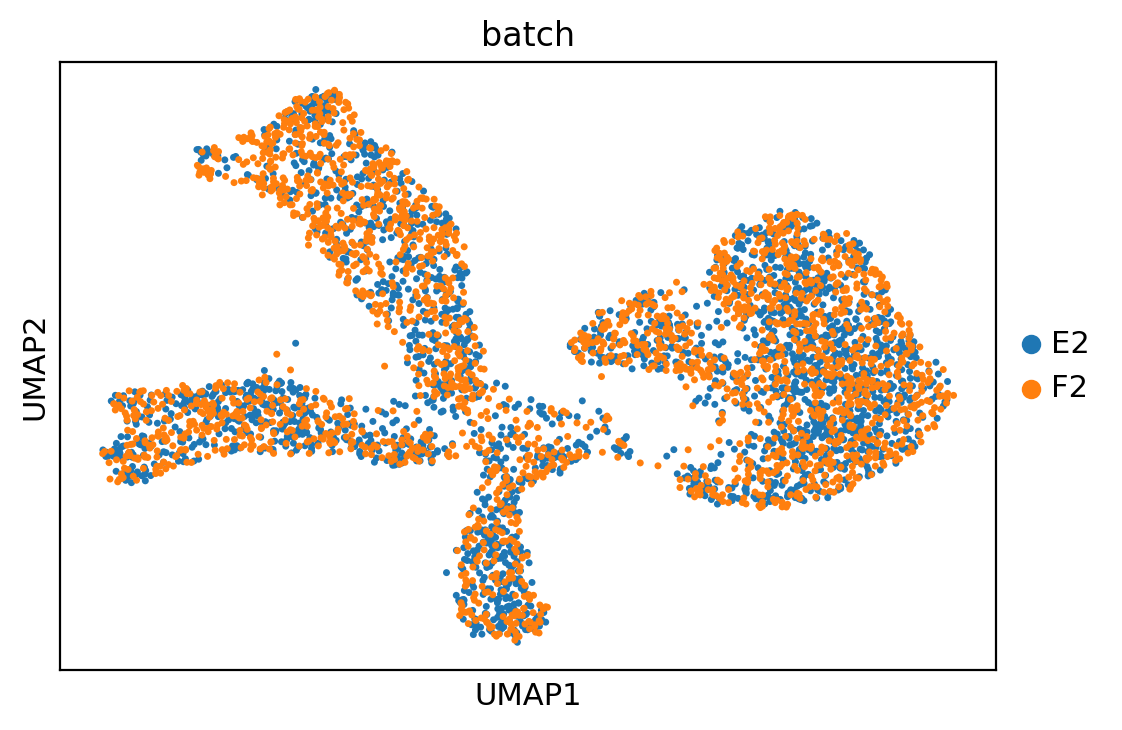

In [103]:
sc.pp.neighbors(adata,
                n_neighbors=100,
                use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.5)
sc.pl.umap(adata, color='batch')

### scVI潜在表現+Leidenによるクラスタリング

同じように、scVI潜在表現で構成された近傍グラフを元にLeidenクラスタリングを実行してみる。上のセルで `scanpy.pp.neighbors` を実行したことにより、adata.obspにはscVI潜在表現で構築された近傍グラフが入っているので、ここでは普通に `scanpy.tl.leiden` を実行すればいい。

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


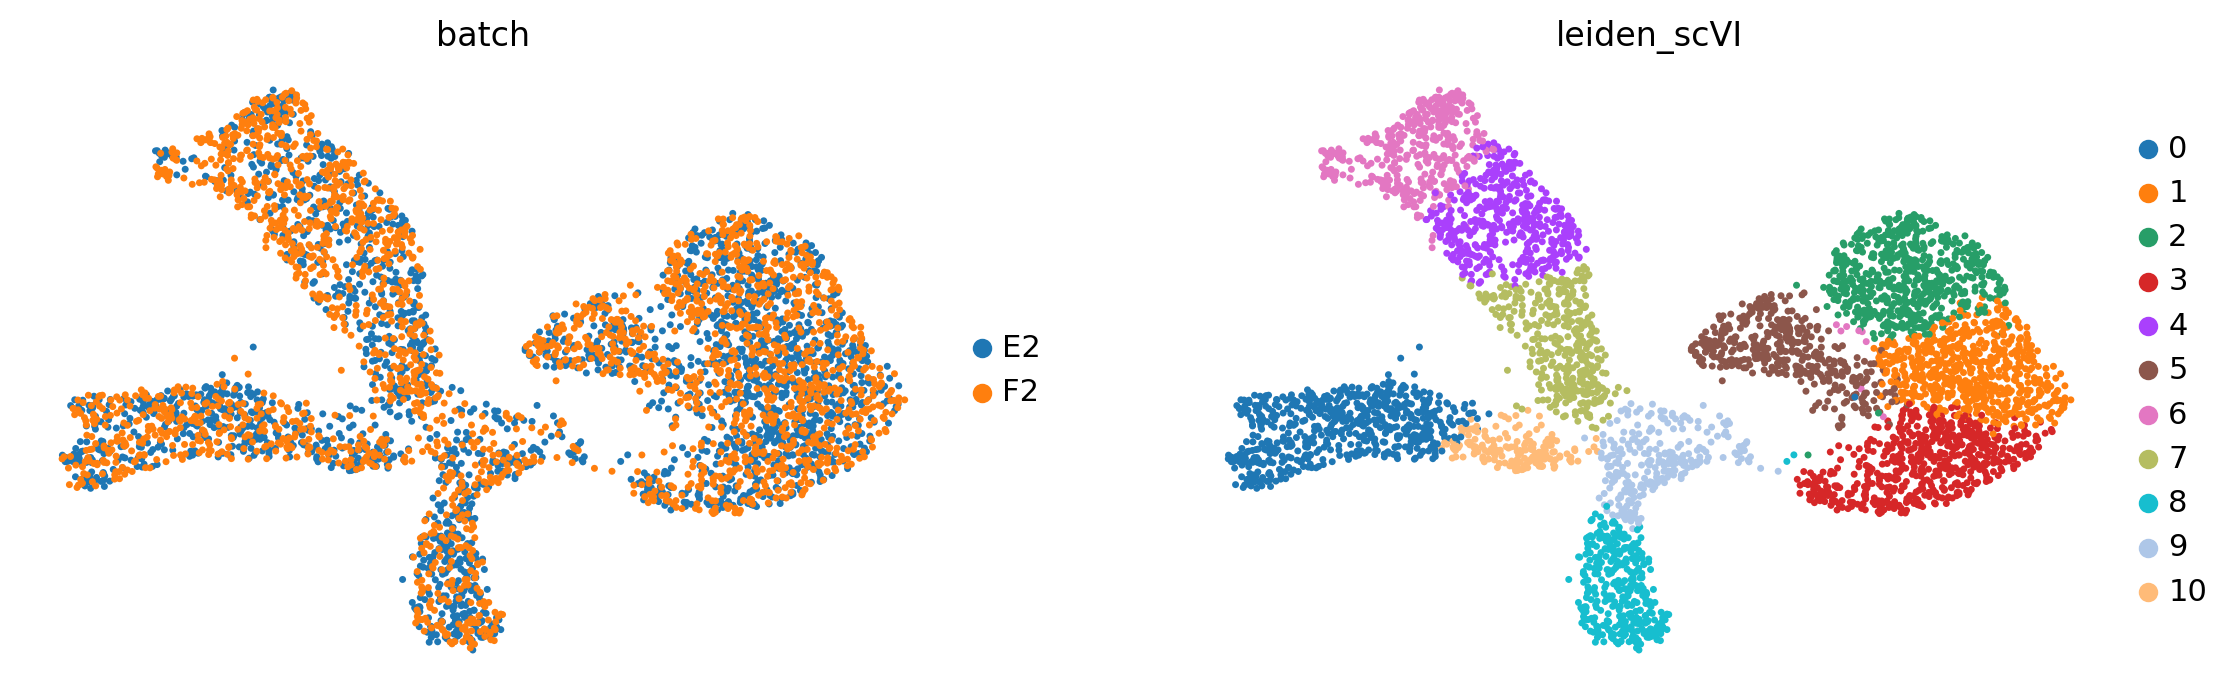

In [104]:
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=1.0)
sc.pl.umap(adata,
           color=['batch', 'leiden_scVI'],
           ncols=2,
           frameon=False)

/usr/local/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:521: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


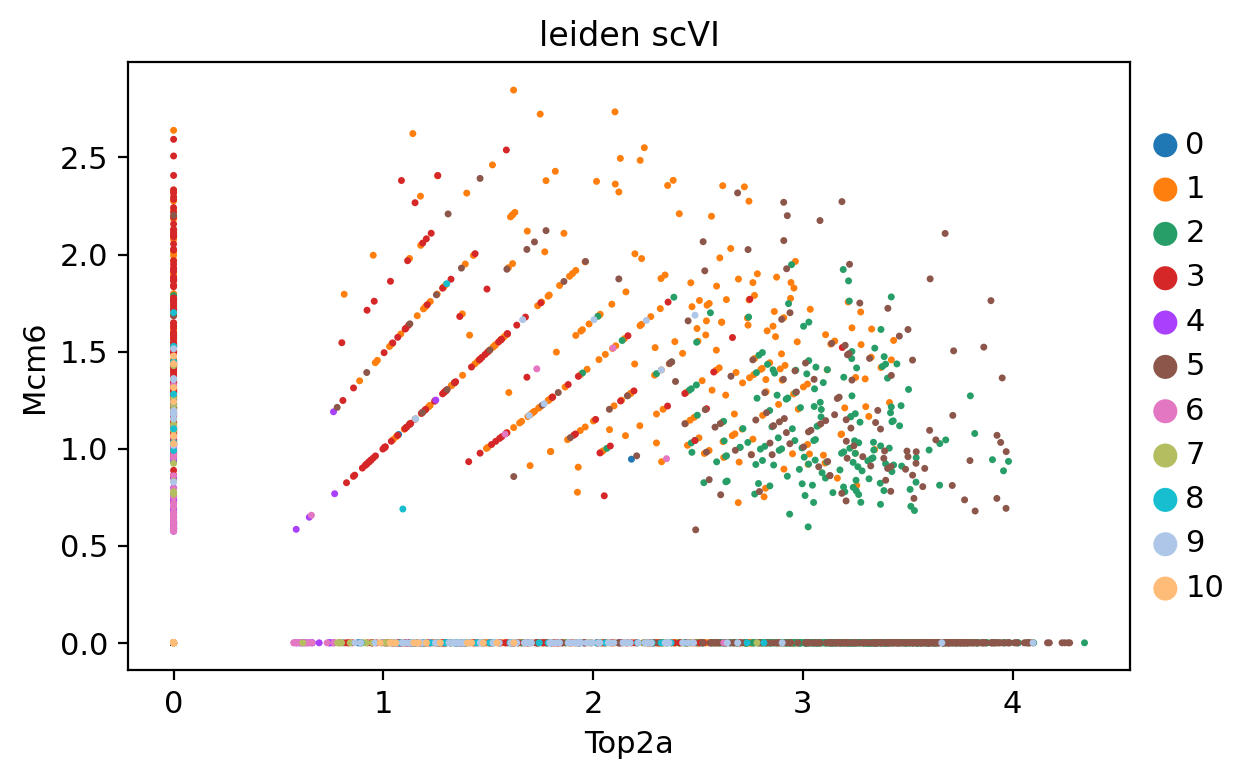

In [105]:
# Top2a, Mcm6の比較でdrop-outが補正されたか確認。
sc.pl.scatter(adata, x='Top2a', y='Mcm6', color='leiden_scVI')

/usr/local/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:521: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


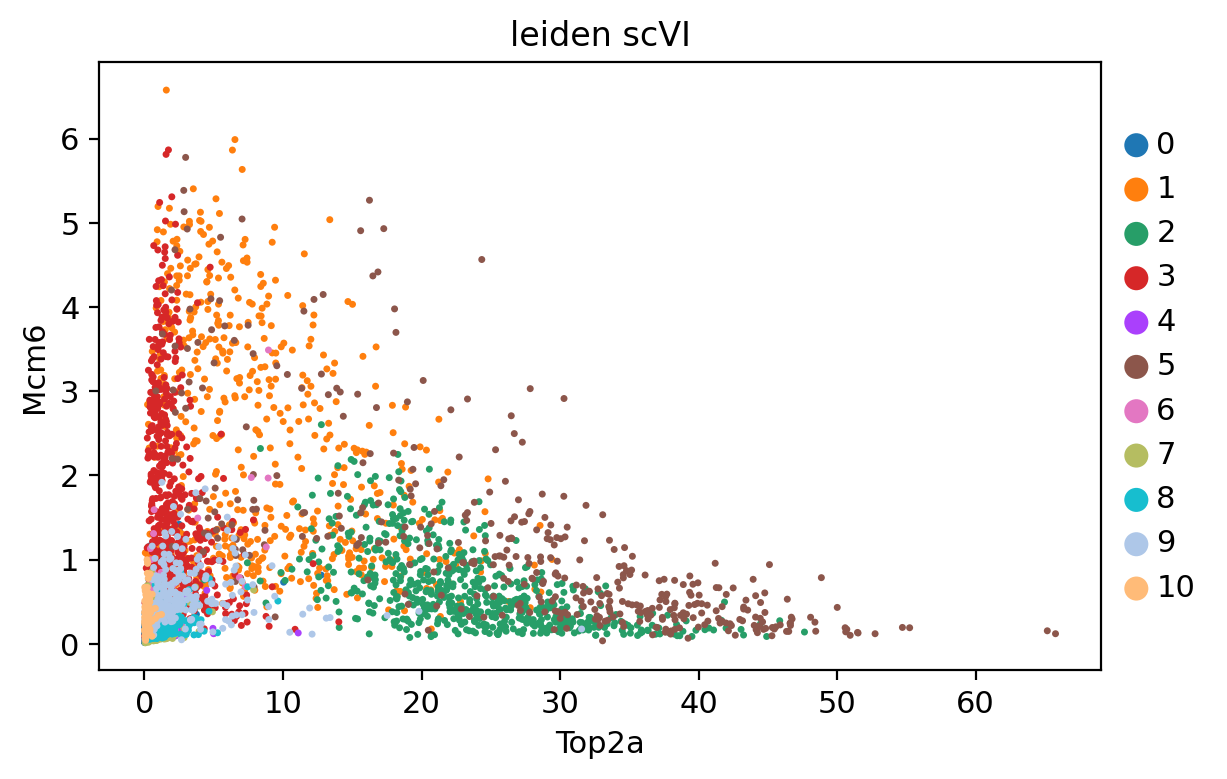

In [106]:
sc.pl.scatter(adata, x='Top2a', y='Mcm6', use_raw=False, layers='scvi_normalized', color='leiden_scVI')

### Doublet検出

[SOLO](https://doi.org/10.1016/j.cels.2020.05.010)によるDoublet検出。

Bernstein, Nicholas J., et al. "Solo: doublet identification in single-cell RNA-Seq via semi-supervised deep learning." Cell systems 11.1 (2020): 95-101.

時間に余裕があればやる。

In [60]:
results = []
for batch in ['F2', 'E2']:
    tmp_solo_model = scvi.external.SOLO.from_scvi_model(
        model, restrict_to_batch=batch)
    tmp_solo_model.train()
    result = tmp_solo_model.predict(soft=False)
    # 意図は不明だがSOLO予測のindexになぜか "-0" が付加されるので消しておく
    result.index = result.index.str.replace("-0$", "", regex=True)
    results.append(result)
results = pd.concat(results)

INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 238/400:  60%|█████▉    | 238/400 [01:03<00:43,  3.74it/s, v_num=1, train_loss_step=0.105, train_loss_epoch=0.127]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.133. Signaling Trainer to stop.
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 278/400:  70%|██████▉   | 278/400 [01:16<00:33,  3.64it/s, v_num=1, train_loss_step=0.0866, train_loss_epoch=0.121]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.109. Signaling Trainer to stop.


In [61]:
adata.obs['SOLO_prediction'] = results[adata.obs.index]

In [62]:
adata.obs['SOLO_prediction'].value_counts()

SOLO_prediction
singlet    4487
doublet     286
Name: count, dtype: int64

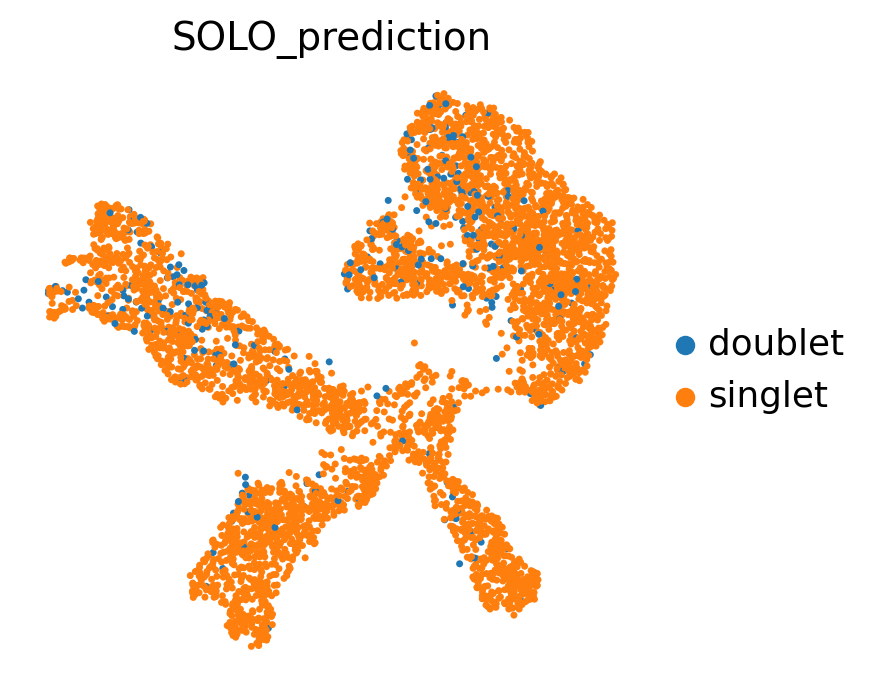

In [63]:
sc.pl.umap(adata, color='SOLO_prediction', frameon=False)

### DEG解析

仮説検定ではなく、ベイズ統計の枠組みでモデル比較を行う。基本的にはある集団と別の集団それぞれの遺伝子発現量期待値（VAEでdenoiseした発現量$\rho_{ng}$）のlog fold changeの値が、ある閾値以下となるか、それ以上の変化があるか、のふたつのモデルで比較する。

`groupby`にラベルを指定すると、そのクラス（この場合はleidenクラスタリングのひとつのクラスタ）とその他全部で自動的に比較してくれる。比較のグループを一部に制限したり、ペアを指定したりいろいろと複雑に組み合わせは指定できる。詳細は[APIのドキュメント](https://docs.scvi-tools.org/en/stable/api/reference/scvi.model.SCVI.html#scvi.model.SCVI.differential_expression)に。

In [64]:
DEs = model.differential_expression(groupby='leiden_scVI')
DEs.head()

DE...: 100%|██████████| 12/12 [02:41<00:00, 13.50s/it]


proba_de  proba_not_de  bayes_factor        scale1    scale2  \
Fam83f    0.9866        0.0134      4.299009  3.518287e-08  0.000002   
Ebf2      0.9800        0.0200      3.891820  8.870040e-07  0.000052   
Impg2     0.9784        0.0216      3.813225  3.562794e-07  0.000016   
Flt1      0.9772        0.0228      3.757930  1.977094e-05  0.000003   
Slfn9     0.9766        0.0234      3.731341  6.416614e-05  0.000009   

        pseudocounts  delta  lfc_mean  lfc_median   lfc_std  ...  raw_mean1  \
Fam83f           0.0   0.25 -4.945087   -5.037920  2.675320  ...   0.000000   
Ebf2             0.0   0.25 -5.698887   -5.924111  3.867369  ...   0.000000   
Impg2            0.0   0.25 -4.459024   -4.436852  3.287869  ...   0.000000   
Flt1             0.0   0.25  4.686607    4.689020  3.671668  ...   0.031949   
Slfn9            0.0   0.25  4.154226    4.053171  2.637717  ...   0.324281   

        raw_mean2  non_zeros_proportion1  non_zeros_proportion2  \
Fam83f   0.004823               0.000000               0.004340   
Ebf2     0.167591               0.000000               0.097902   
Impg2    0.042440               0.000000               0.031830   
Flt1     0.005546               0.027157               0.005305   
Slfn9    0.039547               0.228435               0.034242   

        raw_normalized_mean1  raw_normalized_mean2  is_de_fdr_0.05  \
Fam83f              0.000000              0.008156            True   
Ebf2                0.000000              0.287636            True   
Impg2               0.000000              0.120721            True   
Flt1                0.067749              0.011310            True   
Slfn9               0.642661              0.082016            True   

        comparison  group1 group2  
Fam83f   0 vs Rest       0   Rest  
Ebf2     0 vs Rest       0   Rest  
Impg2    0 vs Rest       0   Rest  
Flt1     0 vs Rest       0   Rest  
Slfn9    0 vs Rest       0   Rest  

[5 rows x 22 columns]

それぞれのクラスタ「特異的」遺伝子、DEG確率の高い順に上から3つくらい見てみる。

In [65]:
markers = {}
for i, c in enumerate(adata.obs['leiden_scVI'].unique()):
    comparison_label = "{} vs Rest".format(c)
    cluster_df = DEs.loc[DEs['comparison'] == comparison_label]
    cluster_df = cluster_df[cluster_df['lfc_mean'] > 0]
    cluster_df = cluster_df[cluster_df['bayes_factor'] > 3]
    cluster_df = cluster_df[cluster_df['non_zeros_proportion1'] > 0.1]
    markers[c] = cluster_df.index.tolist()[:3]

図でLeidenクラスタのデンドログラムを表示したいので事前に計算しておく。

In [66]:
sc.tl.dendrogram(adata, groupby='leiden_scVI', use_rep='X_scVI')

クラスタ間での遺伝子発現量の比較は、`scanpy.pl.dotplot`が見やすくて便利。上で抽出したマーカー遺伝子を指定して、表示する発現量の数値としてはadata.rawに格納したデータで描画する。

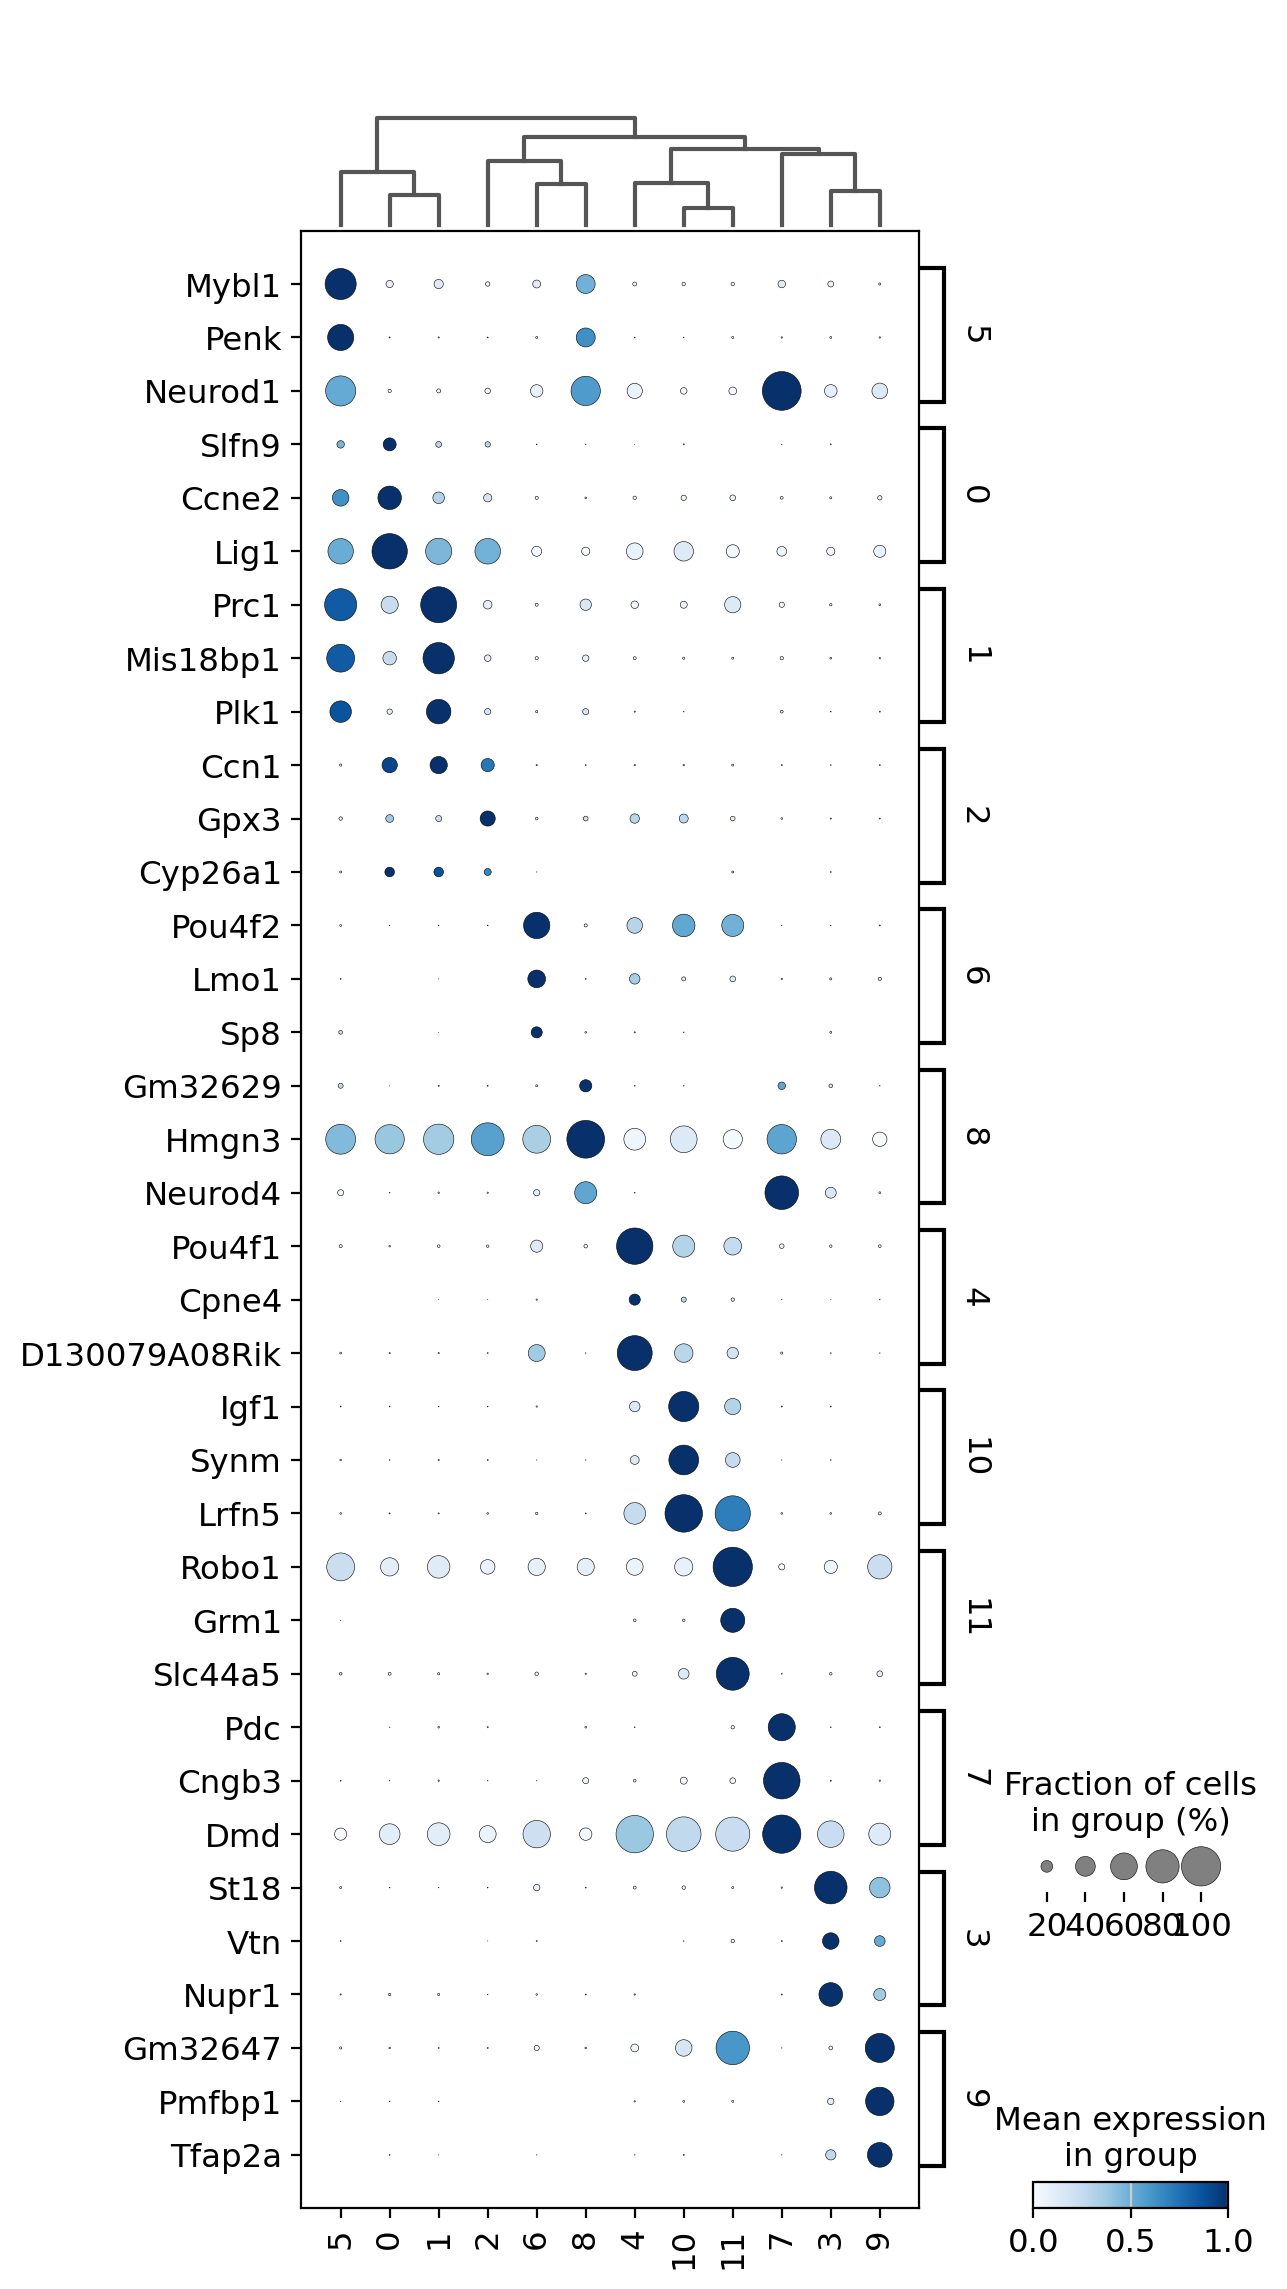

In [67]:
sc.pl.dotplot(
    adata,
    markers,
    groupby='leiden_scVI',
    dendrogram=True,
    color_map="Blues",
    swap_axes=True,
    use_raw=True,
    standard_scale='var')

クラスタ平均値ではなくクラスタごと細胞ごとの全部の（scVIノーマライズされた）発現量でヒートマップを描くこともできる。

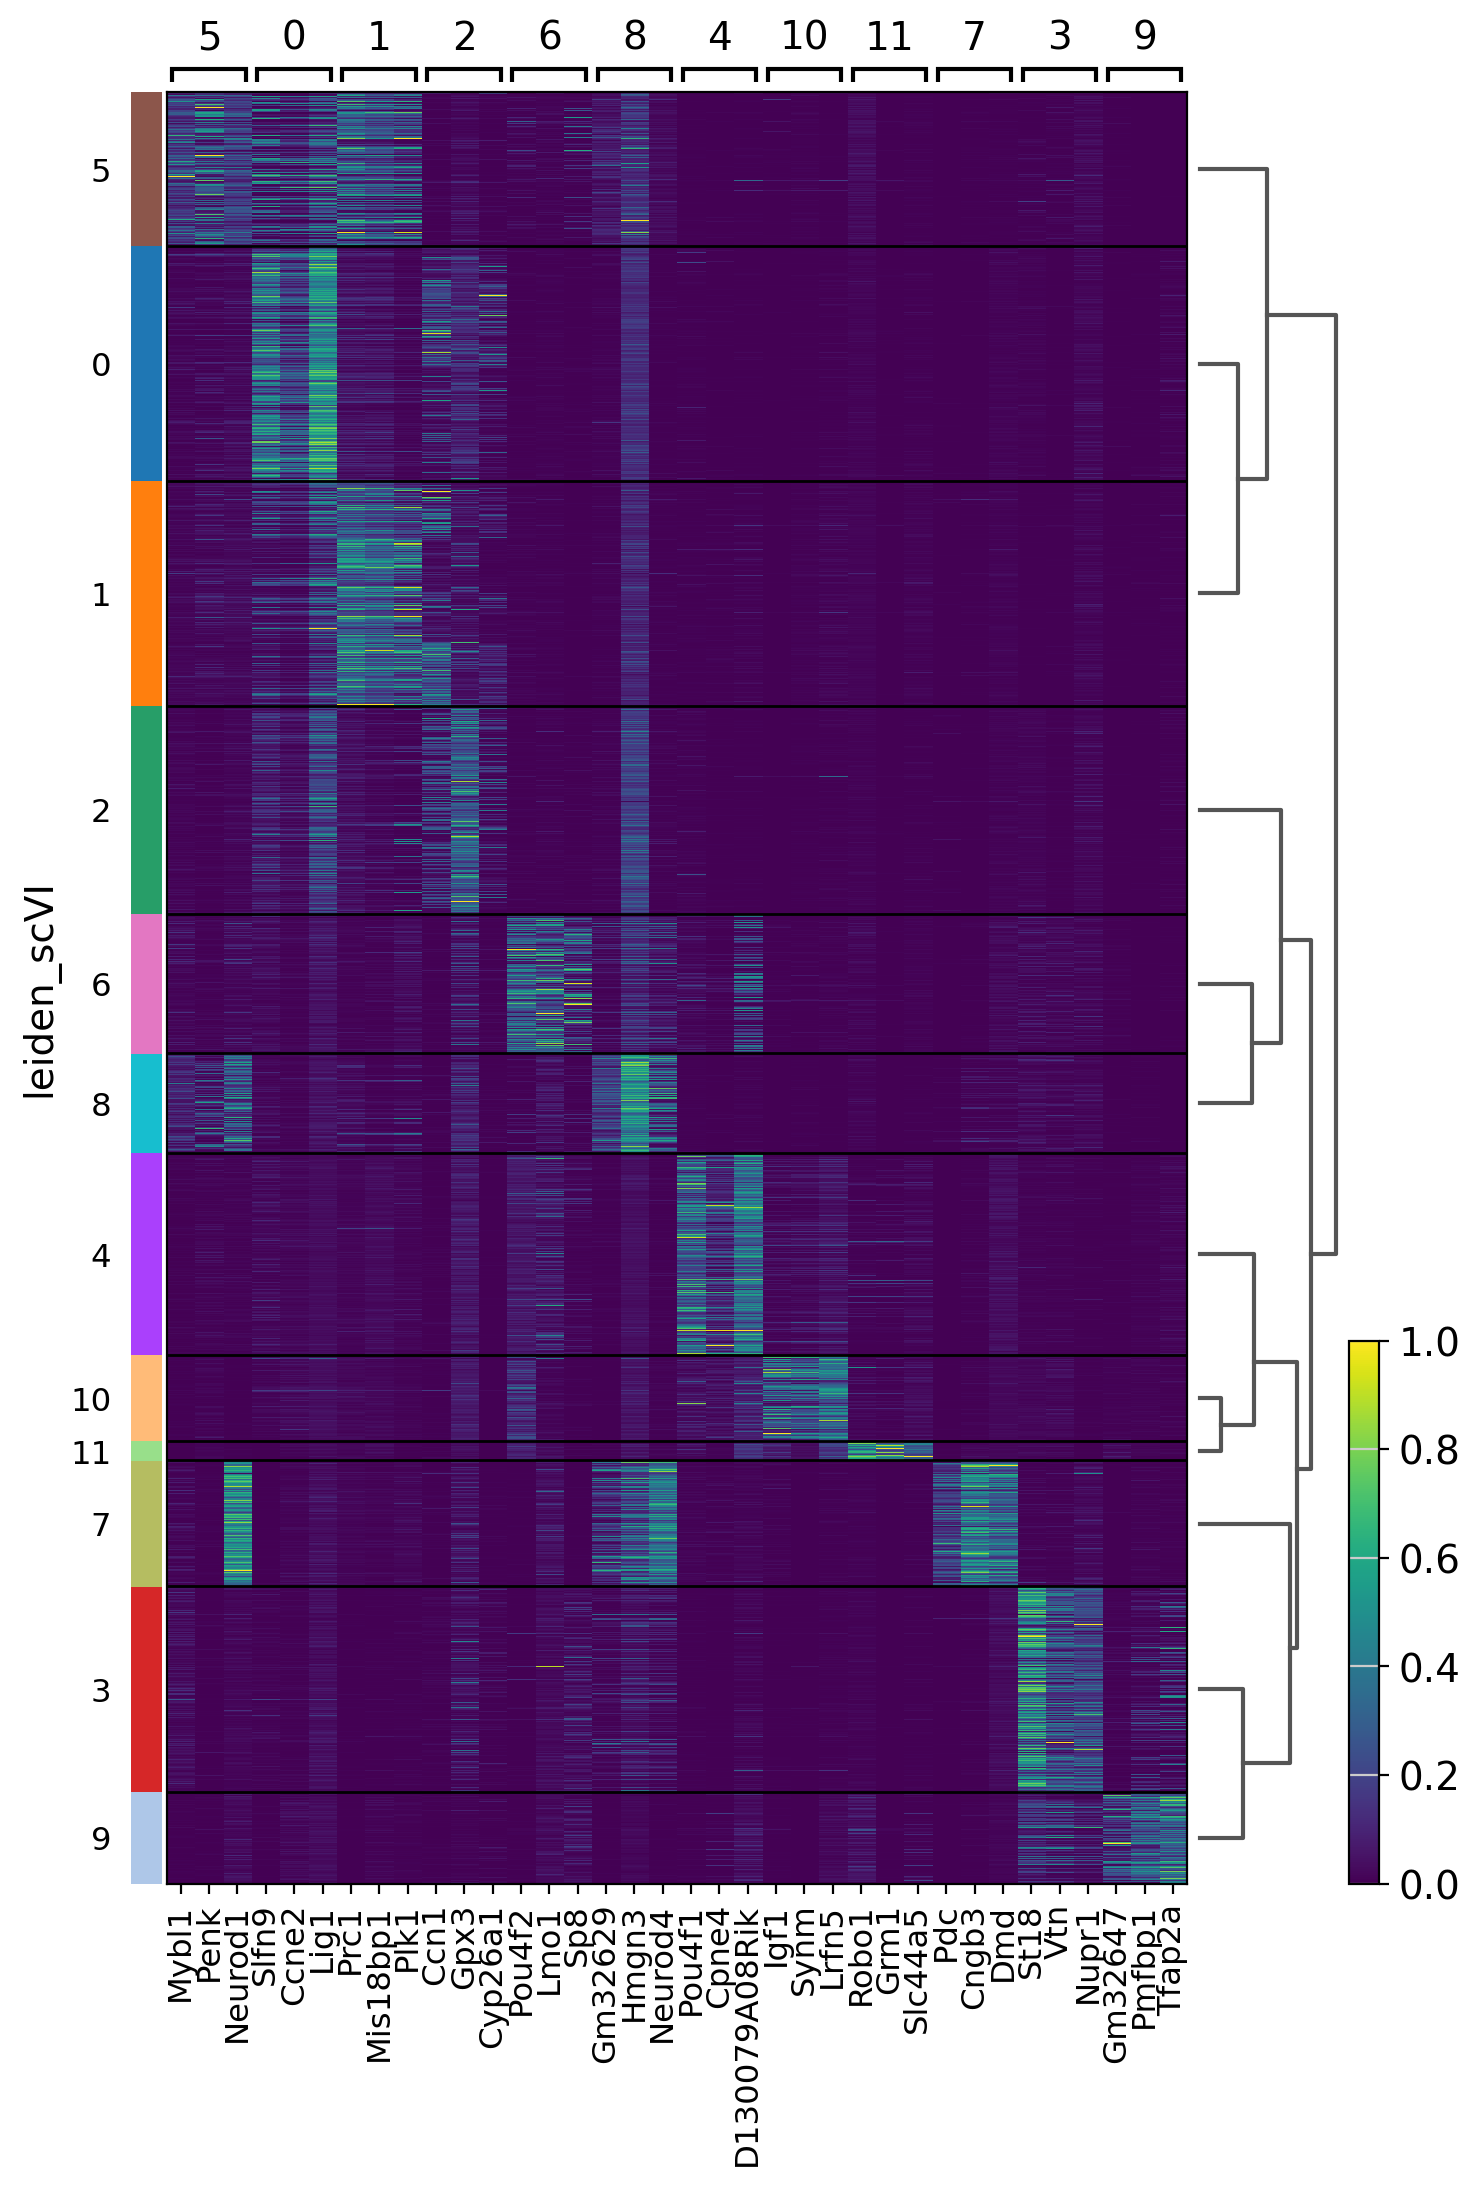

In [68]:
sc.pl.heatmap(
    adata,
    markers,
    groupby='leiden_scVI',
    layer='scvi_normalized',
    standard_scale="var",
    dendrogram=True,
    figsize=(8, 12)
)

## RNA速度の推定

### 事前準備（velocyto）

scVeloを使うためには、spliced/unsplicedの二種類のカウントデータが必要となる。

なので事前に [velocyto](http://velocyto.org/velocyto.py/index.html) を使って、Cell Rangerが生成したゲノムマッピングのBAMファイルから、spliced/unsplicedのカウントデータを作っておく。

バッチごとに実行して、それぞれのバッチに属する細胞のspliced/unsplicedカウントを格納した [loom](https://linnarssonlab.org/loompy/index.html) データを作る。

計算に時間がかかるので、講習ではすでにvelocyto計算済みの結果を配布している。

velocytoは以下のコマンドで実行する。

```bash
velocyto run10x \
    -m /path/to/Cell_Ranger_References/mm10_rmsk.gtf \
    /path/to/RetinalBatchE2 \
    /path/to/Cell_Ranger_References/refdata-gex-mm10-2020-A/genes/genes.gtf

velocyto run10x \
    -m /path/to/Cell_Ranger_References/mm10_rmsk.gtf \
    /path/to/RetinalBatchF2 \
    /path/to/Cell_Ranger_References/refdata-gex-mm10-2020-A/genes/genes.gtf
```

velocytoでバッチごとに推定したloomファイルを統合して書き出す。ここの統合処理も時間かかるので、統合後のデータを配布。

In [71]:
%%script true
import loompy
loompy.combine(['./data/RetinalBatchE2/velocyto/RetinalBatchE2.loom',
                './data/RetinalBatchF2/velocyto/RetinalBatchF2.loom'],
               output_file='./data/retinal_velo.loom')

In [72]:
import scvelo as scv
scv.set_figure_params()

spliced/unsplicedのカウントデータを遺伝子発現テーブルと統合する。細胞のバーコードで紐づけるので、長さの指定（インデックスのどの部分がバーコードか）が必要になることに注意。

In [74]:
ldata = scv.read('./data/retinal_velo.loom', cache=True)

# id_lengthは細胞を区別するバーコード配列の長さ。事前に確認しておく
# また、scVIのmerge関数は勝手にこれまでのクラスタの色指定をリセットしちゃうので一時退避させて再設定しておく
# 'uns'(unstructured)は特に構造の決まってない雑多なメタデータを格納しておく場所。
cluster_colors = adata.uns['leiden_scVI_colors']
adata = scv.utils.merge(adata, ldata, id_length=16)
adata.uns['leiden_scVI_colors'] = cluster_colors

scVeloの関数で、遺伝子ごとのspliced/unsplicedカウントの比率を表示できる。実験プラットフォームにもよるが、だいたいunsplicedが25%程度らしい。クラスタごとにも表示。極端にunsplicedがとれてないクラスタがあるかどうかチェックする。

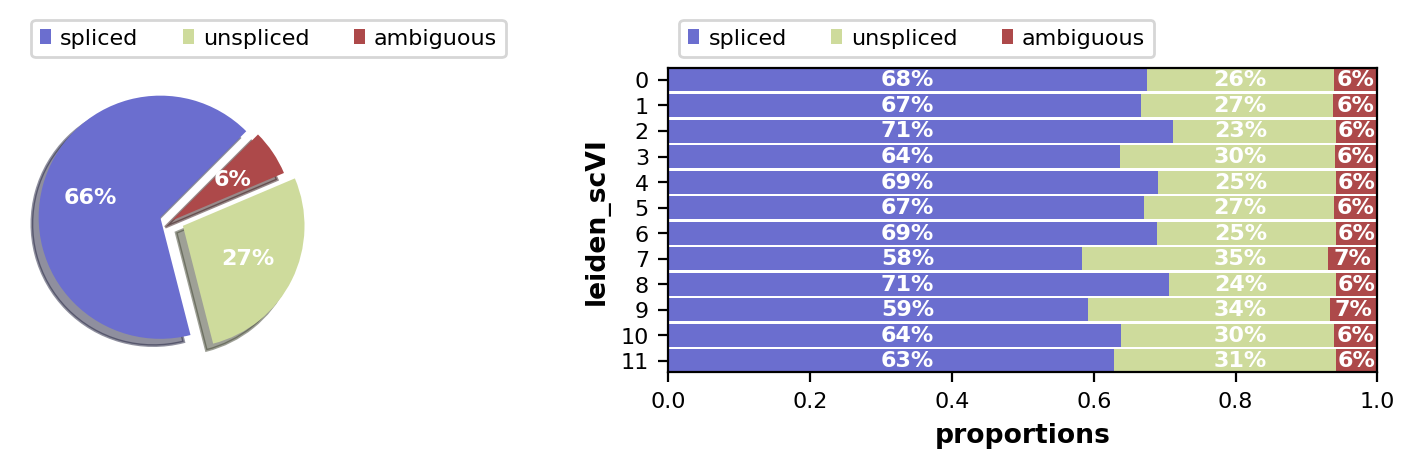

In [75]:
scv.pl.proportions(adata, groupby='leiden_scVI')

速度計算を実行する。近傍グラフの構成から。

In [76]:
# scVI補完の潜在空間上で近傍グラフ構成、一次・二次モーメント計算
scv.pp.moments(adata, use_rep='X_scVI')

Normalized count data: spliced, unspliced.
computing moments based on connectivities
    finished (0:00:05) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


Splicing kineticsモデルのパラメータ推論。

In [77]:
scv.tl.velocity(adata, mode='stochastic')

computing velocities


/usr/local/lib/python3.10/site-packages/scvelo/tools/optimization.py:184: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[i] = np.linalg.pinv(A.T.dot(A)).dot(A.T.dot(y[:, i]))


    finished (0:00:14) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


速度ベクトルを元に、細胞から細胞への遷移確率を計算。

In [78]:
scv.tl.velocity_graph(adata)

computing velocity graph (using 1/2 cores)


  0%|          | 0/4773 [00:00<?, ?cells/s]

    finished (0:00:29) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


速度ベクトルから構成した「流れ」をプロットしてみる。

/usr/local/lib/python3.10/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/usr/local/lib/python3.10/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/usr/local/lib/python3.10/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/usr/local/lib/python3.10/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and wi

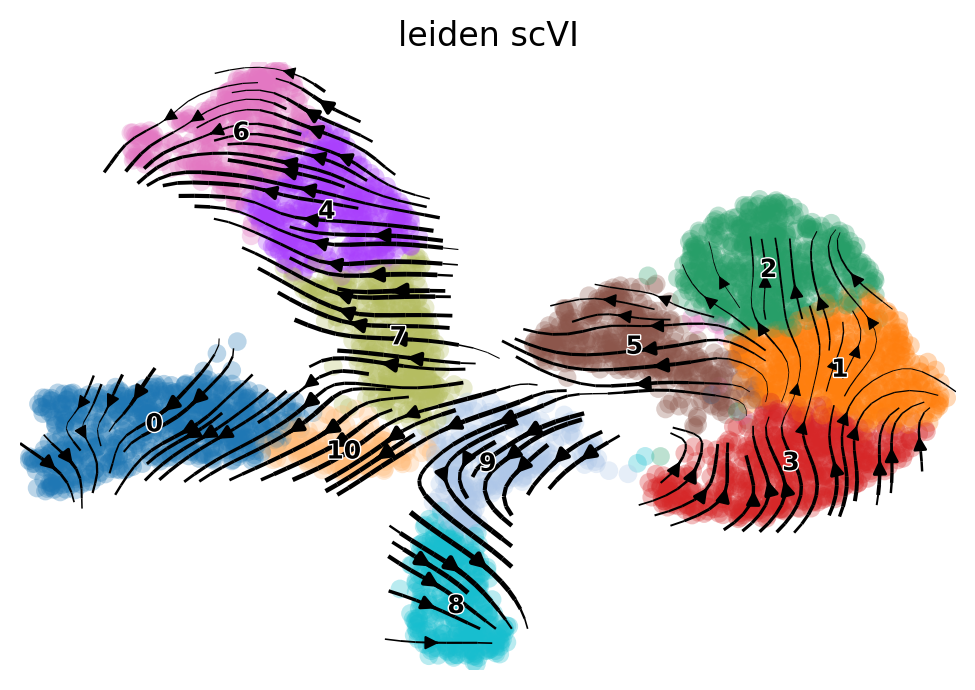

In [107]:
scv.pl.velocity_embedding_stream(adata,
        basis='X_umap', color='leiden_scVI',
        legend_fontsize=9,
        smooth=0.8, min_mass=4)

Progenitorの部分がごちゃごちゃしてわかりにくいので、取り出して個別に解析してみる。

In [108]:
prog = adata[adata.obs['leiden_scVI'].isin(['1', '2', '3', '5'])].copy()

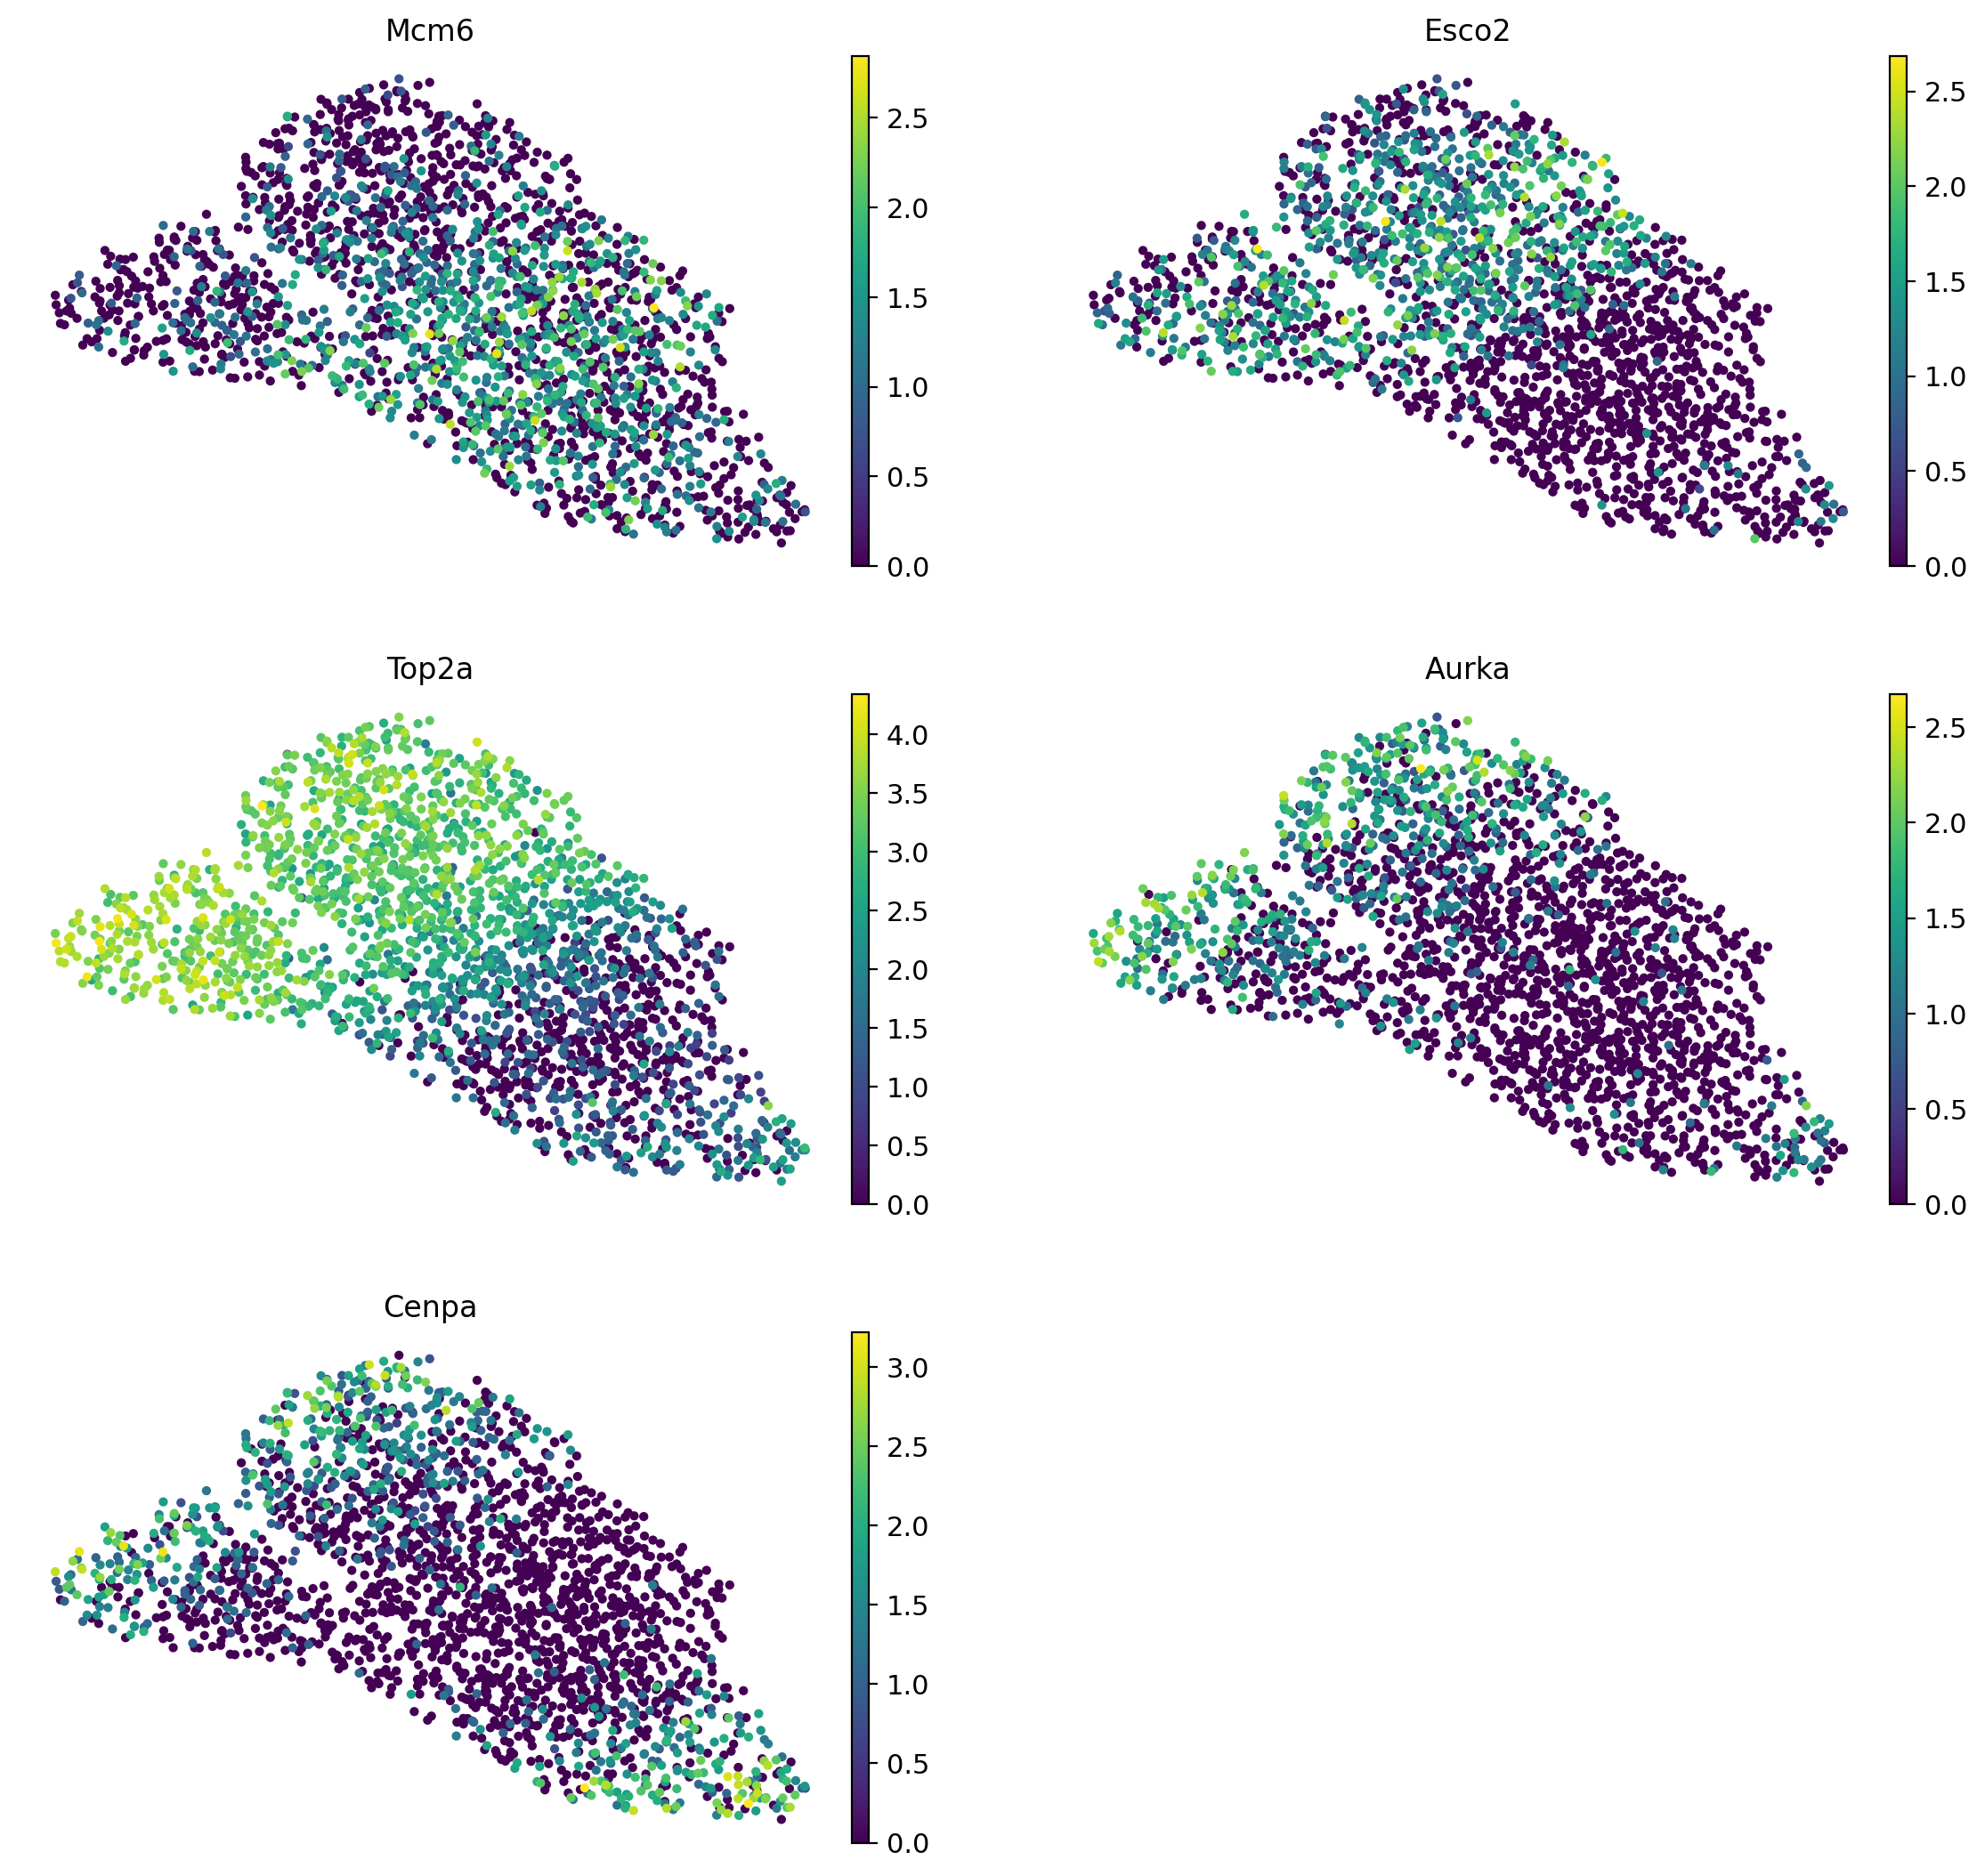

In [112]:
sc.pp.neighbors(prog, use_rep="X_scVI", n_neighbors=50)
sc.tl.umap(prog, min_dist=1.0)
sc.pl.umap(prog,
           ncols=2,
           color=['Mcm6', 'Esco2', 'Top2a', 'Aurka', 'Cenpa'],
           cmap='viridis',
           frameon=False)

computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities


/usr/local/lib/python3.10/site-packages/scvelo/tools/optimization.py:184: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[i] = np.linalg.pinv(A.T.dot(A)).dot(A.T.dot(y[:, i]))


    finished (0:00:03) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/2 cores)


  0%|          | 0/2185 [00:00<?, ?cells/s]

    finished (0:00:08) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


/usr/local/lib/python3.10/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/usr/local/lib/python3.10/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/usr/local/lib/python3.10/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/usr/local/lib/python3.10/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and wi

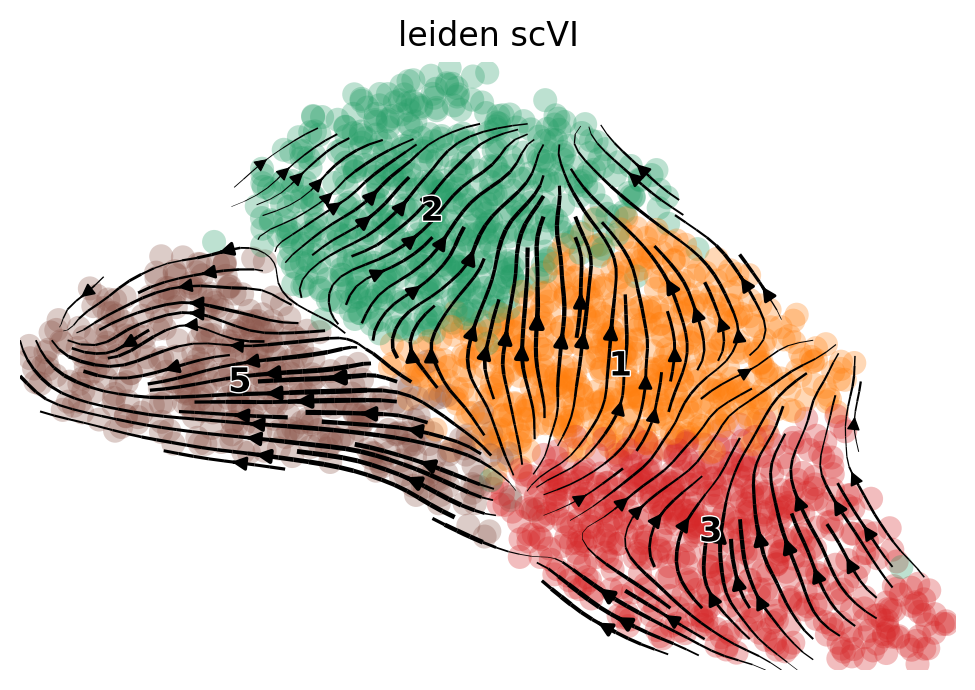

In [113]:
scv.pp.moments(prog, use_rep='X_scVI')
scv.tl.velocity(prog, mode='stochastic')
scv.tl.velocity_graph(prog)
scv.pl.velocity_embedding_stream(prog,
    basis='X_umap', color='leiden_scVI',
    smooth=0.8, min_mass=4)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
